In [1]:
import dask
dask.config.set({"dataframe.query-planning": False})

import itertools
import scanpy as sc
import gseapy
import liana
import scipy
import numpy as np
import pandas as pd
import sys
import argparse
import json
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path

sys.path.append("../../../workflow/scripts/")
import _utils
import readwrite
cfg = readwrite.config()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you a

## Plot results diffexpr

In [7]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
signal_integrity_thresholds = [0.5,0.7]
correction_methods = ['raw','resolvi','resolvi_supervised'] + [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
num_samples = 30
mixture_k = 50
normalisations = ['lognorm',]
layers = ['data',]
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'

n_neighbors = 10
n_permutations = 30
n_repeats = 5
top_n = 20
scoring = 'f1'
markers = 'diffexpr' #'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/cellmarker_cell_types_markers.json'

# needed to get unique cell types names for each level
# cell_types_palette = pd.read_csv(palette_dir / 'col_palette_cell_types_combo.csv')

df_diffexpr = {}
df_diffexpr_corrected_counts = {}
df_markers_rank_significance_diffexpr = {}
df_markers_rank_significance_diffexpr_corrected_counts = {}

for correction_method in correction_methods:
    df_markers_rank_significance_diffexpr[correction_method] = {}

    for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
        if segmentation.stem == 'proseg_mode':
            continue
        for condition in (conditions := segmentation.iterdir()): 
            for panel in (panels := condition.iterdir()):
                for donor in (donors := panel.iterdir()):
                    for sample in (samples := donor.iterdir()):
                        for normalisation in normalisations:
                            for layer in layers:

                                k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                                name = '/'.join(k)
                                print(correction_method,k,end='\n')

                                if correction_method == 'raw':
                                    ### raw results
                                    out_file_df_diffexpr = results_dir / f'contamination_metrics_diffexpr/{name}/{normalisation}/{layer}_{reference}_{method}_{level}_diffexpr.parquet'
                                    out_file_df_markers_rank_significance_diffexpr = results_dir / f'contamination_metrics_diffexpr/{name}/{normalisation}/{layer}_{reference}_{method}_{level}_markers_rank_significance_diffexpr.parquet'

                                ### count correction results
                                else:
                                    if correction_method == "resolvi":
                                        name_corrected = f'{name}/{mixture_k=}/{num_samples=}/'
                                    elif correction_method == "resolvi_supervised":
                                        name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}'
                                    elif "ovrlpy" in correction_method:
                                        name_corrected = f'{name}'

                                    out_file_df_ctj_marker_genes = results_dir /  f'contamination_metrics_diffexpr_corrected_counts/{correction_method}/{name_corrected}/{normalisation}/{layer}_{reference}_{method}_{level}_marker_genes.parquet'
                                    out_file_df_diffexpr = results_dir / f'contamination_metrics_diffexpr_corrected_counts/{correction_method}/{name_corrected}/{normalisation}/{layer}_{reference}_{method}_{level}_diffexpr.parquet'
                                    out_file_df_markers_rank_significance_diffexpr = results_dir / f'contamination_metrics_diffexpr_corrected_counts/{correction_method}/{name_corrected}/{normalisation}/{layer}_{reference}_{method}_{level}_markers_rank_significance_diffexpr.parquet'
                                

                                if out_file_df_diffexpr.exists():
                                    # df_diffexpr_corrected_counts[k] = pd.read_parquet(out_file_df_diffexpr)
                                    df_markers_rank_significance_diffexpr[correction_method][k] = pd.read_parquet(out_file_df_markers_rank_significance_diffexpr)

raw ('proseg_expected', 'breast', 'breast', '1FYB', '1FYB')
raw ('proseg_expected', 'breast', 'breast', 'OPHI', 'OPHI_3')
raw ('proseg_expected', 'breast', 'breast', 'OPHI', 'OPHI_1')
raw ('proseg_expected', 'breast', 'breast', 'OPHI', 'OPHI_2')
raw ('proseg_expected', 'breast', 'breast', '1BCA', '1BCA')
raw ('proseg_expected', 'breast', 'breast', '0PD6', '0PD6')
raw ('proseg_expected', 'breast', 'breast', '1256', '1256')
raw ('proseg_expected', 'breast', 'breast', '1GV1', '1GV1')
raw ('proseg_expected', 'breast', 'breast', '1GVR', '1GVR')
raw ('proseg_expected', 'breast', 'breast', '1FHZ', '1FHZ')
raw ('proseg_expected', 'breast', 'breast', '0U9A', '0U9A')
raw ('proseg_expected', 'breast', 'breast', '1ESQ', '1ESQ')
raw ('proseg_expected', 'breast', 'breast', '0VRA', '0VRA')
raw ('proseg_expected', 'breast', 'breast', '14LZ', '14LZ')
raw ('proseg_expected', 'breast', 'breast', '1H27', '1H27')
raw ('proseg_expected', 'breast', 'breast', '1GUC', '1GUC')
raw ('proseg_expected', 'breast', 

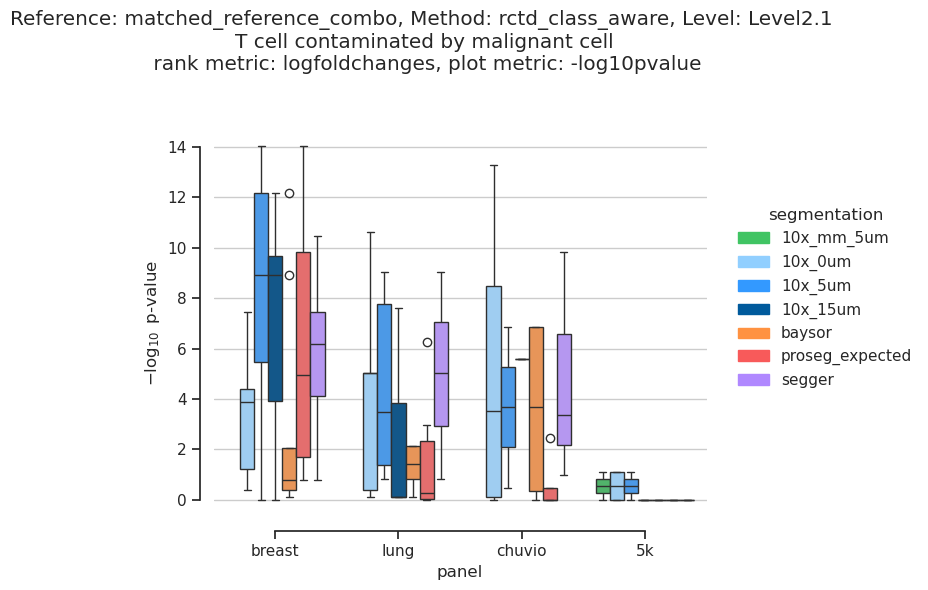

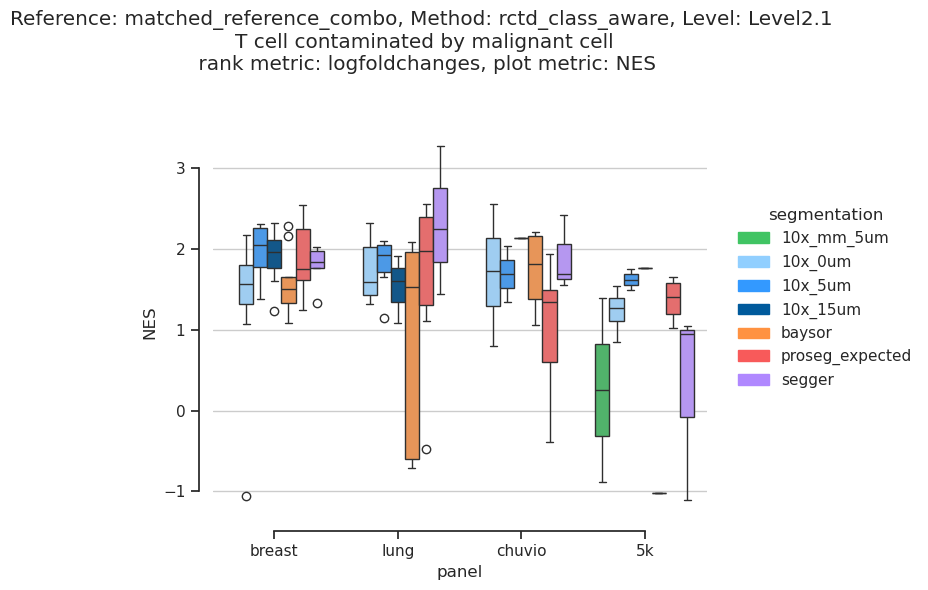

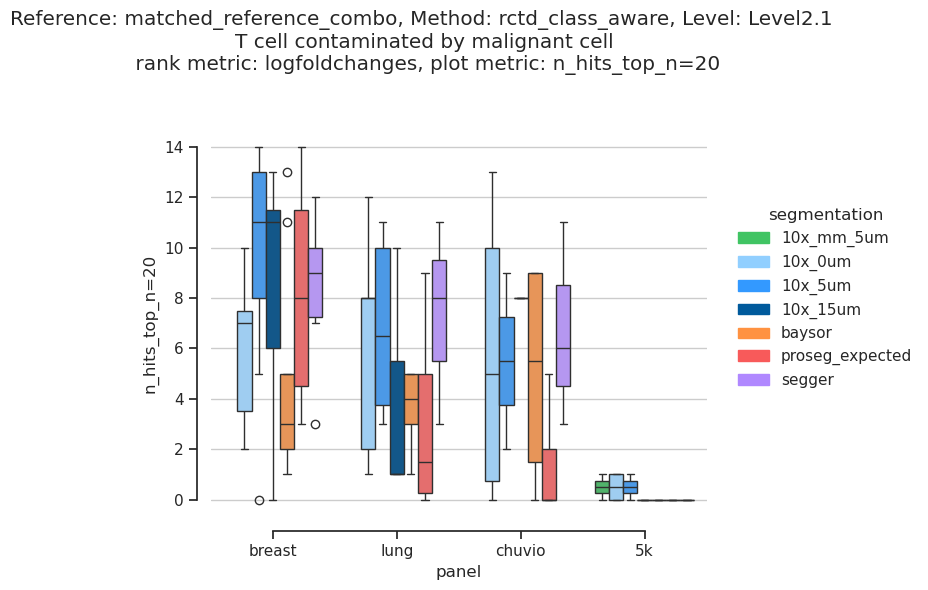

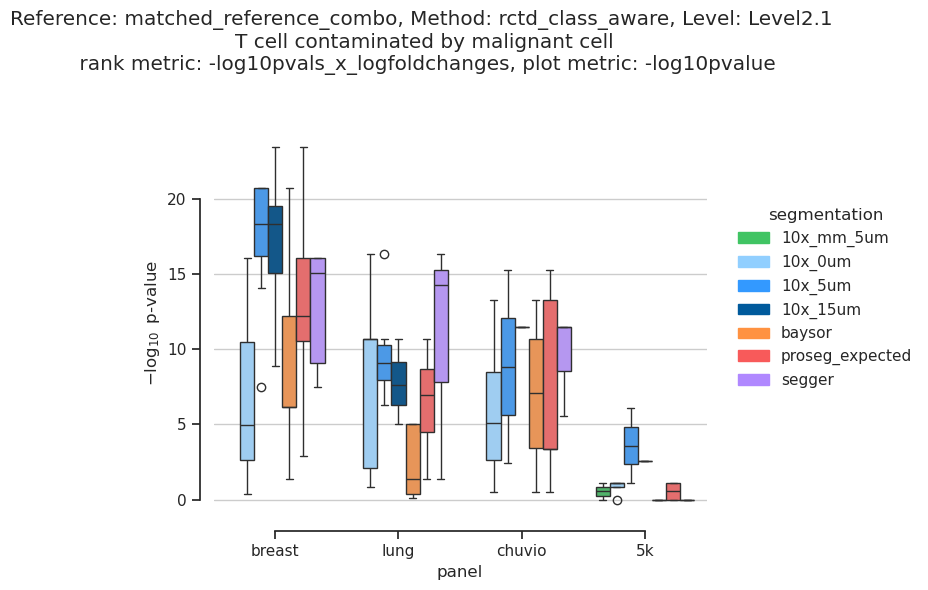

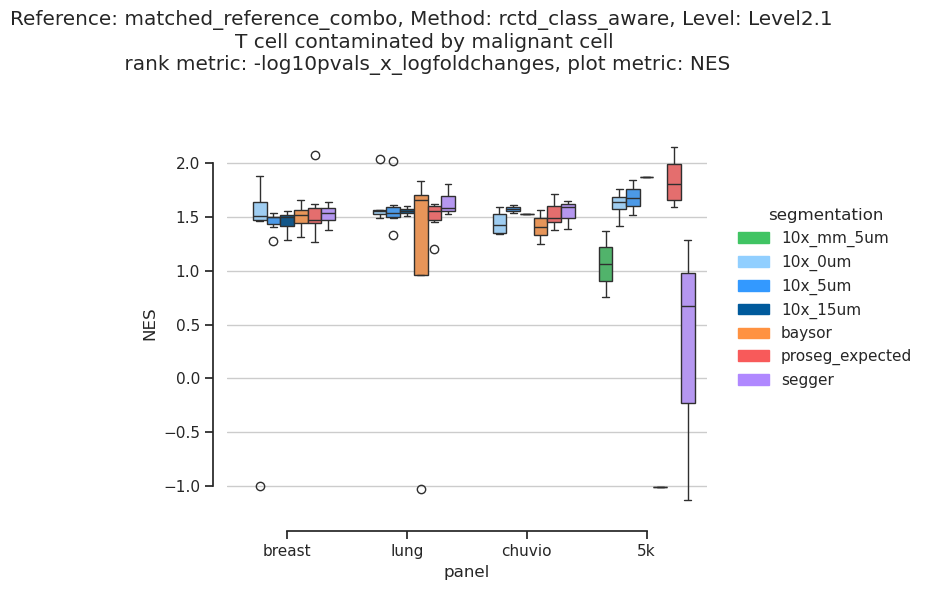

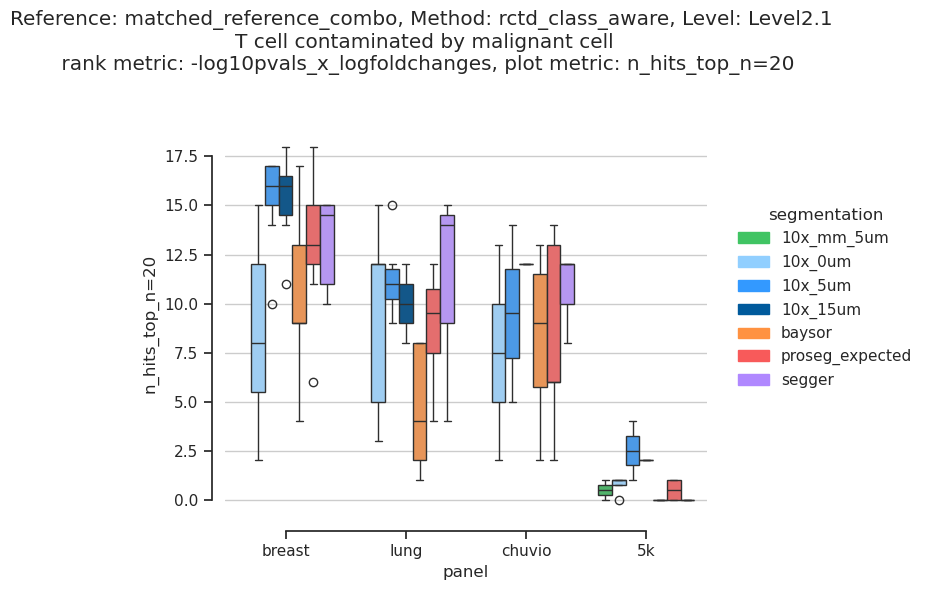

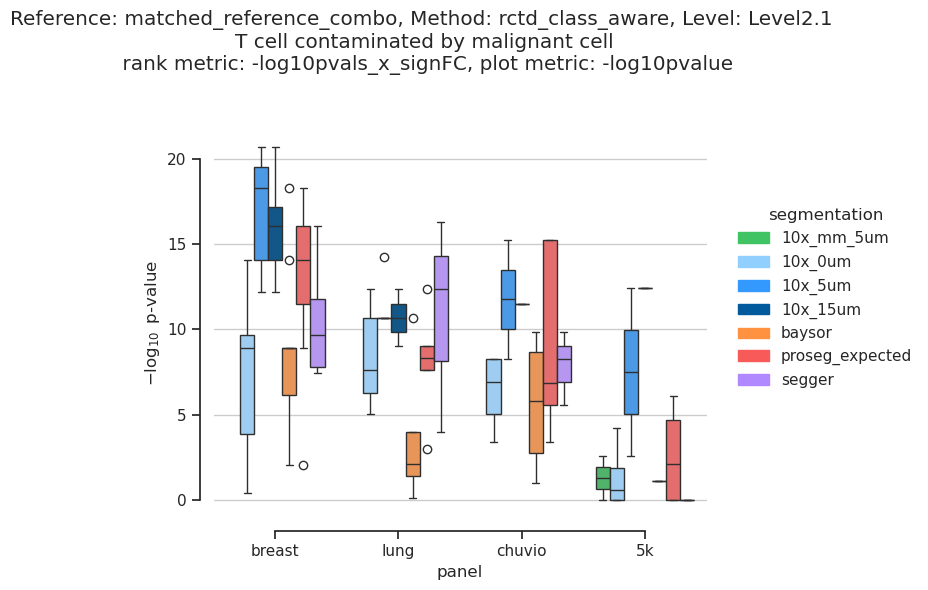

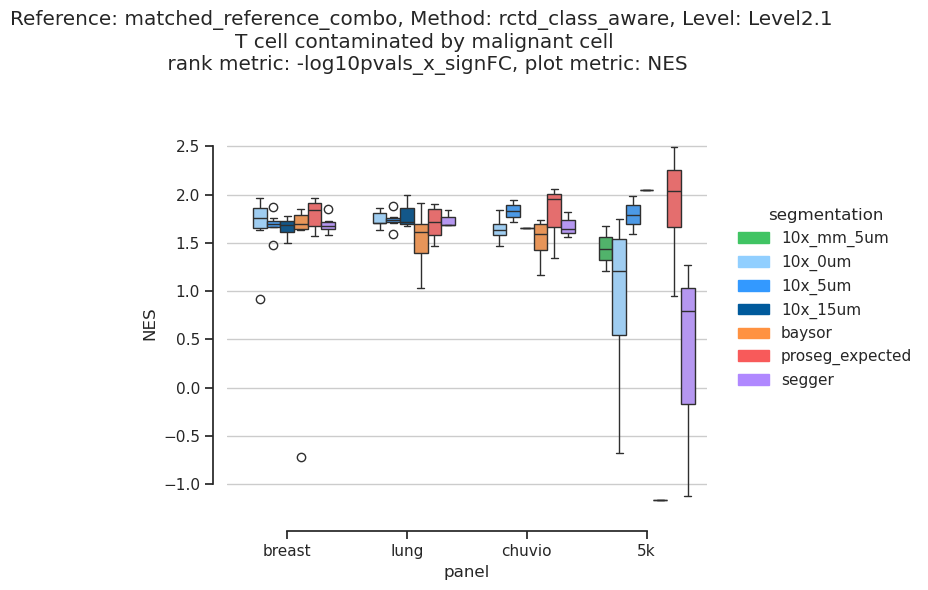

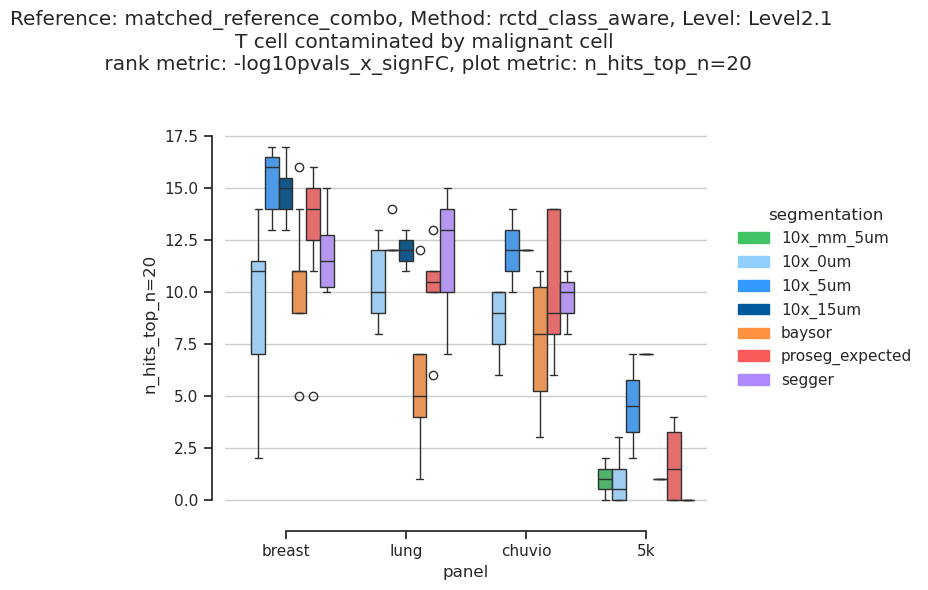

In [145]:
count_correction_method = 'raw'
rank_metrics = ["logfoldchanges", "-log10pvals_x_logfoldchanges", "-log10pvals_x_signFC"]
plot_metrics = ['hypergeometric_pvalue','NES',f"n_hits_{top_n=}"]

cti = 'T cell'
ctj = 'malignant cell'
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample","cti","ctj"]

hue = "segmentation"
hue_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]


palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:

        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({k: v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()}).reset_index()
        df.columns = xenium_levels + df.columns[len(xenium_levels) :-1].tolist() + [plot_metric]
        df = df.query("cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric])
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_order if c in np.unique(df[hue].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        sns.set(style="ticks")

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 6))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax
                        )
        if plot_metric == '-log10pvalue':
            plt.ylabel(r'$-\log_{10} \text{ p-value}$')
        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue,
            frameon=False,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()


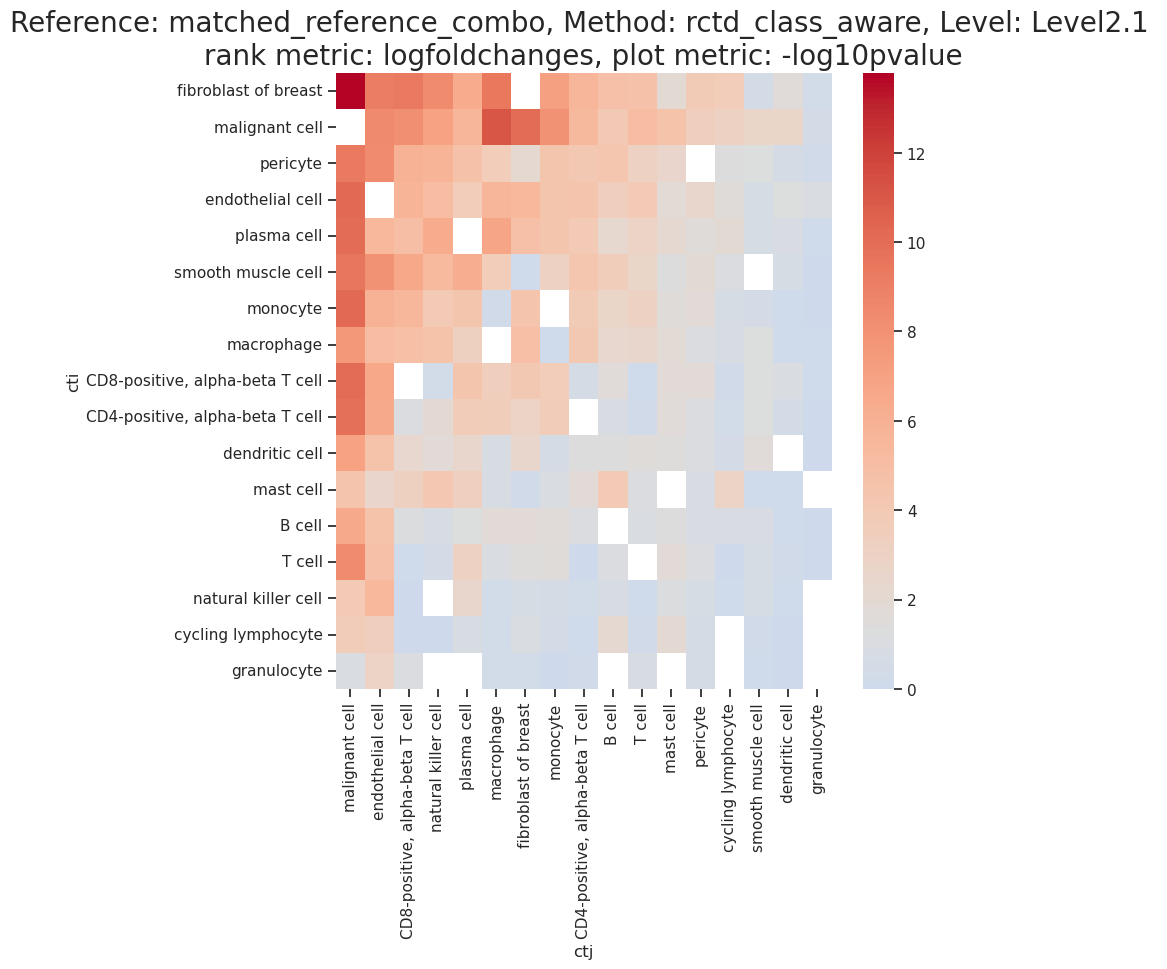

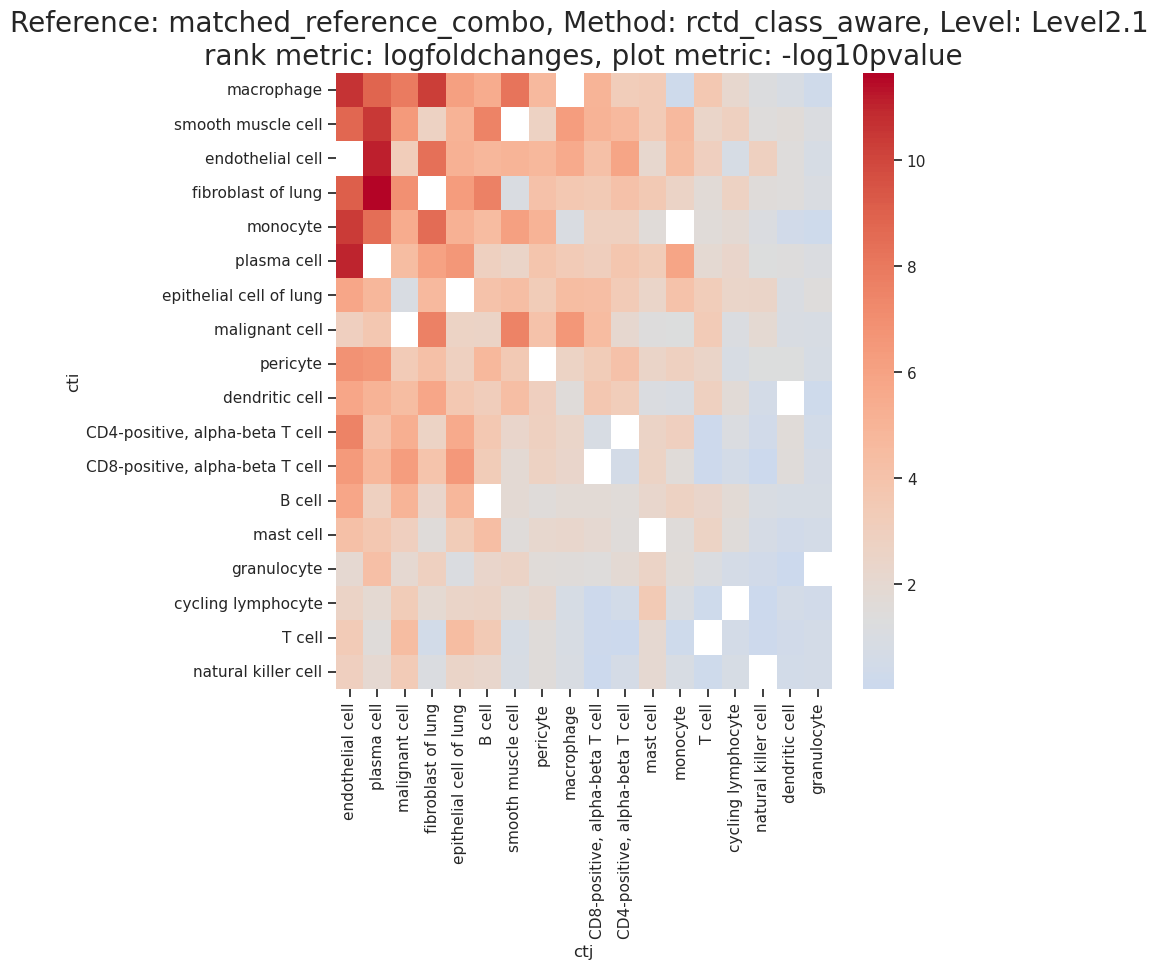

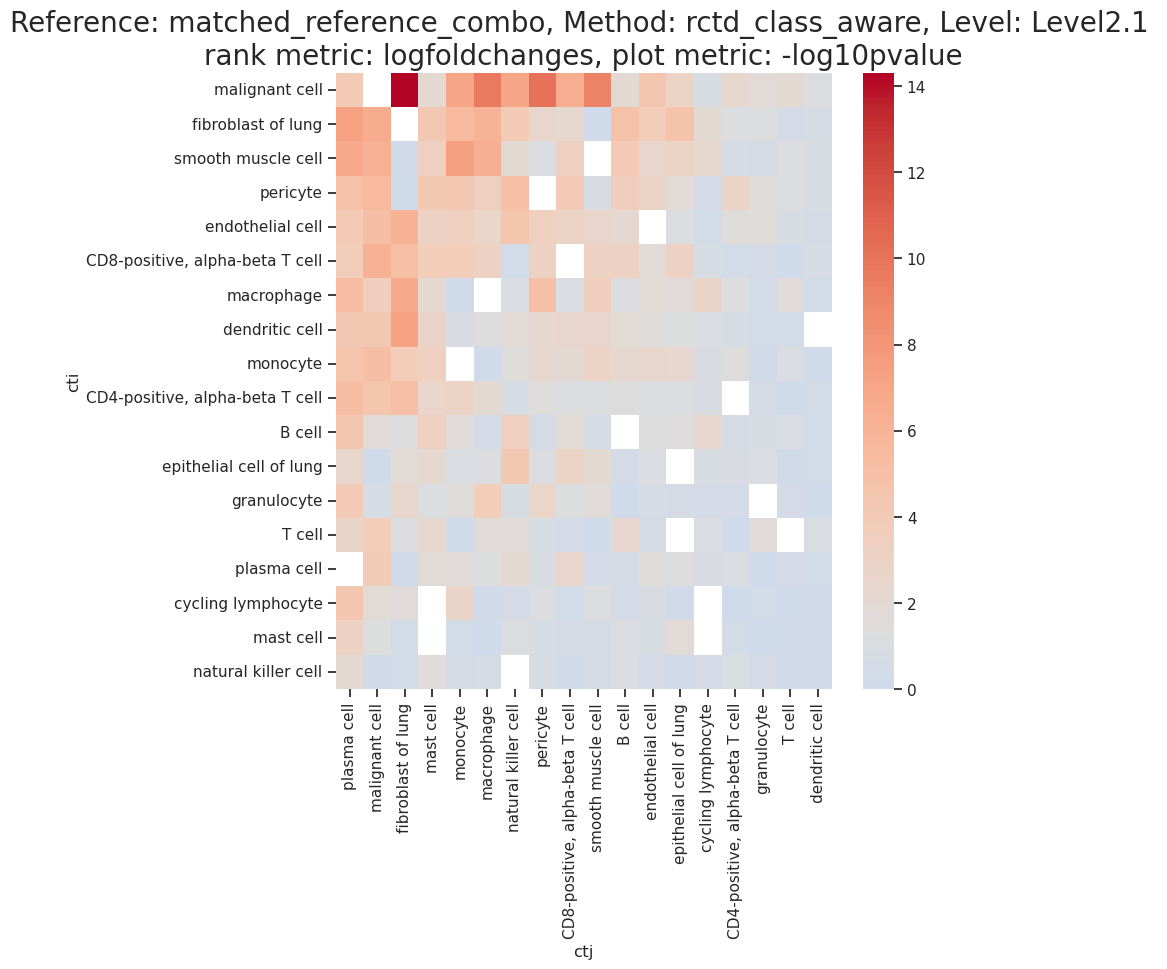

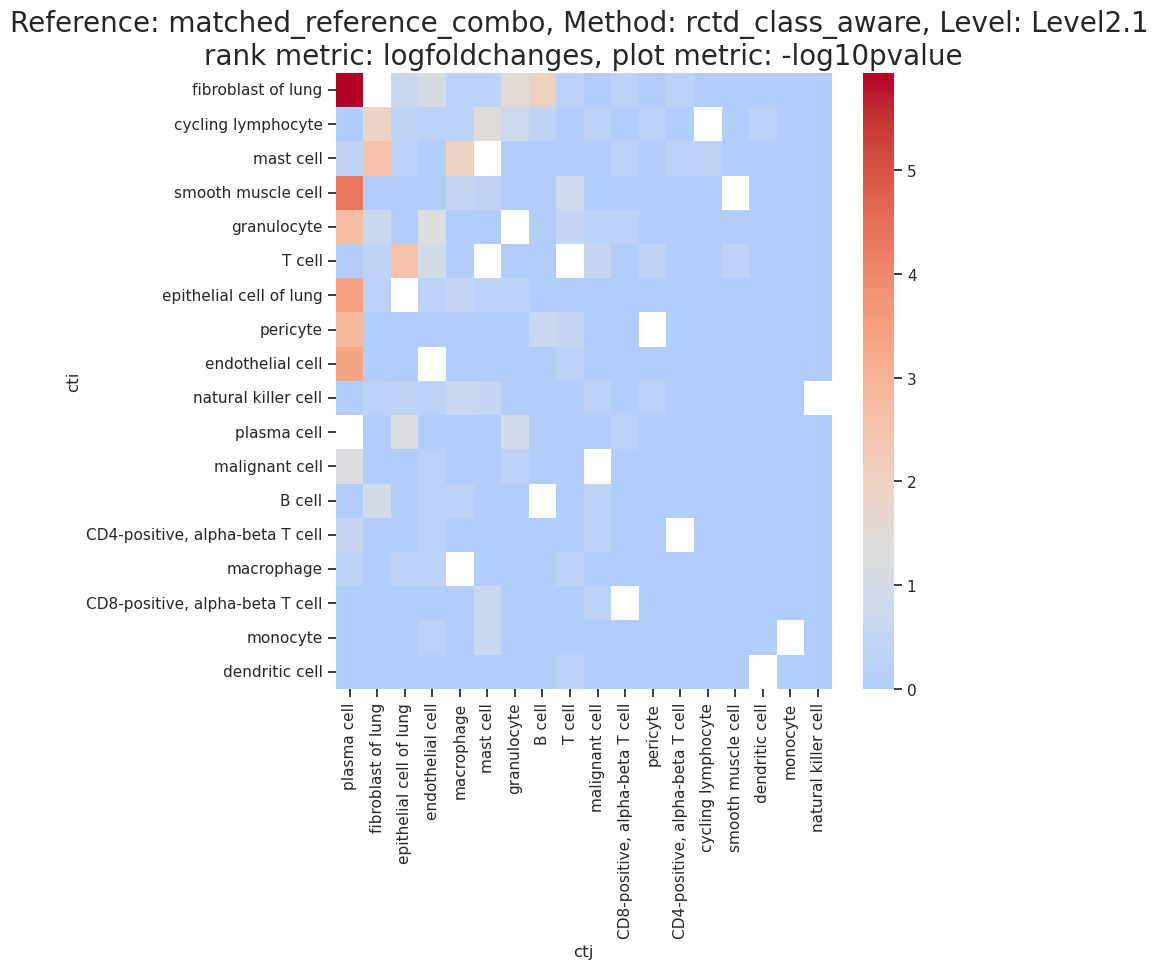

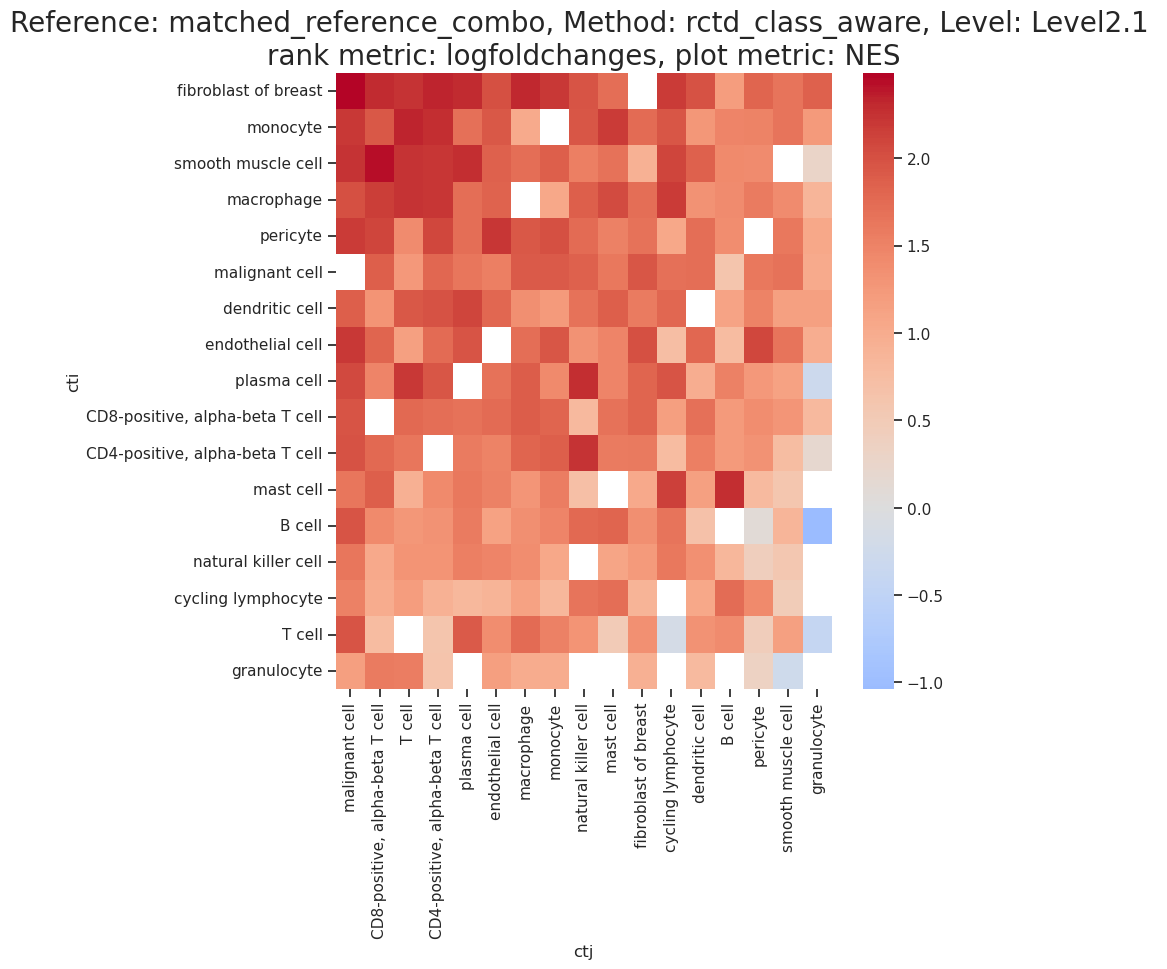

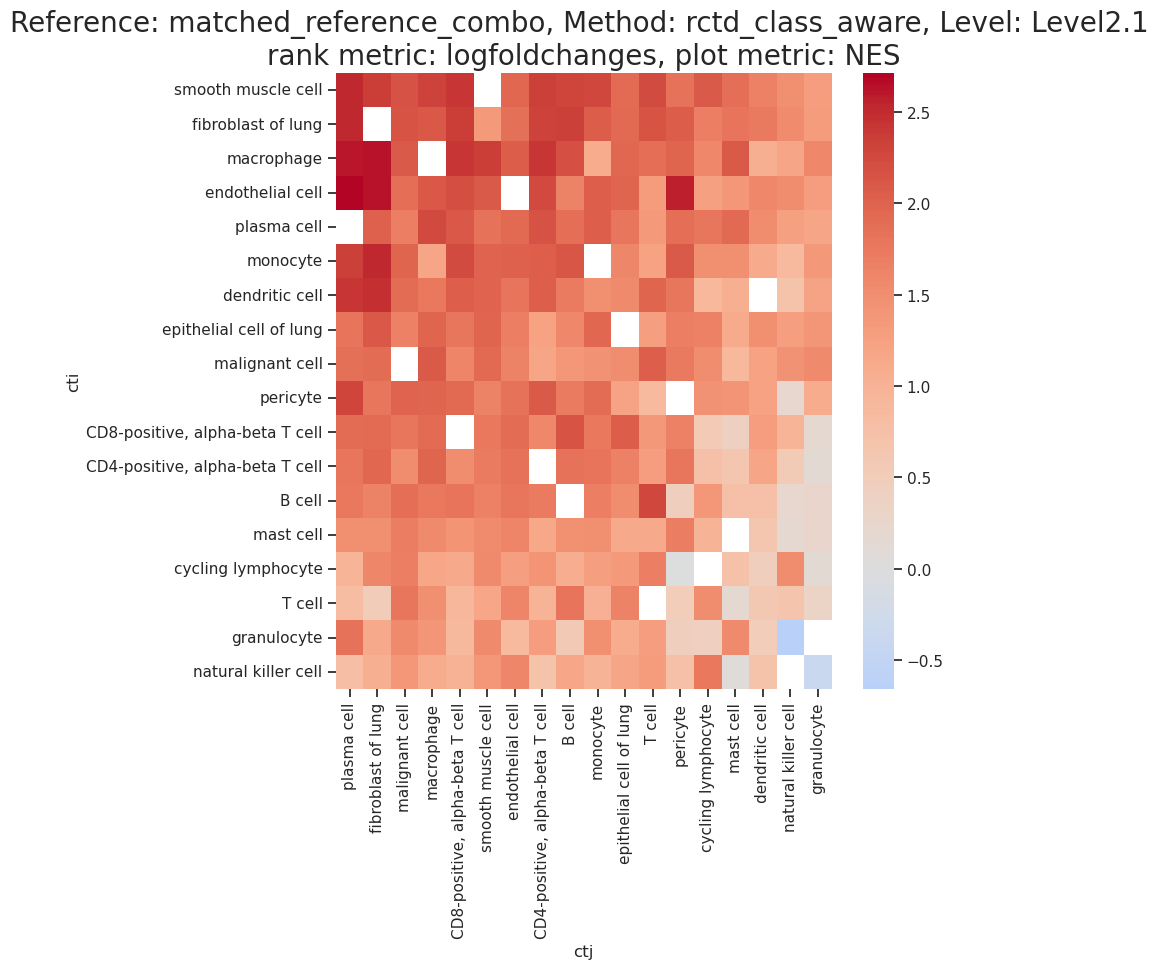

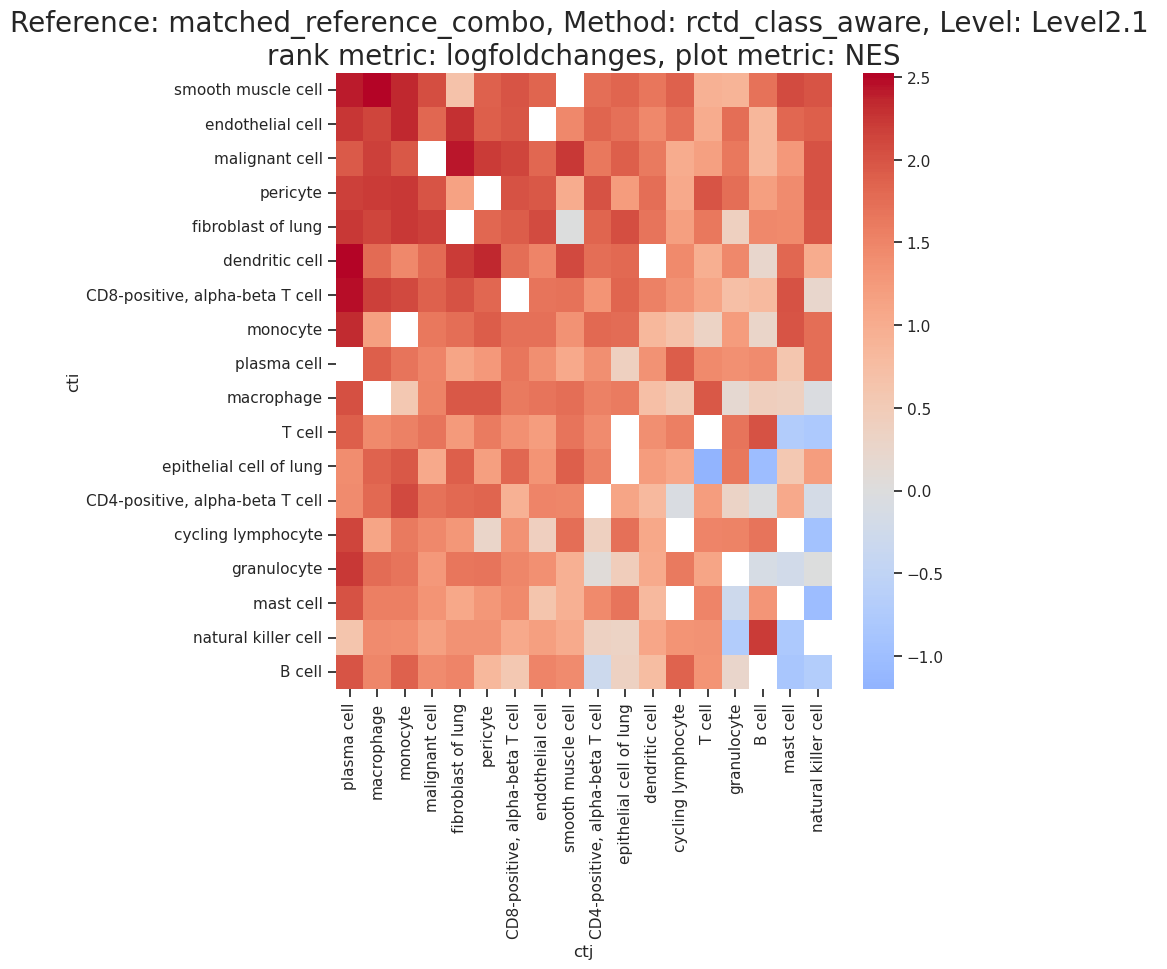

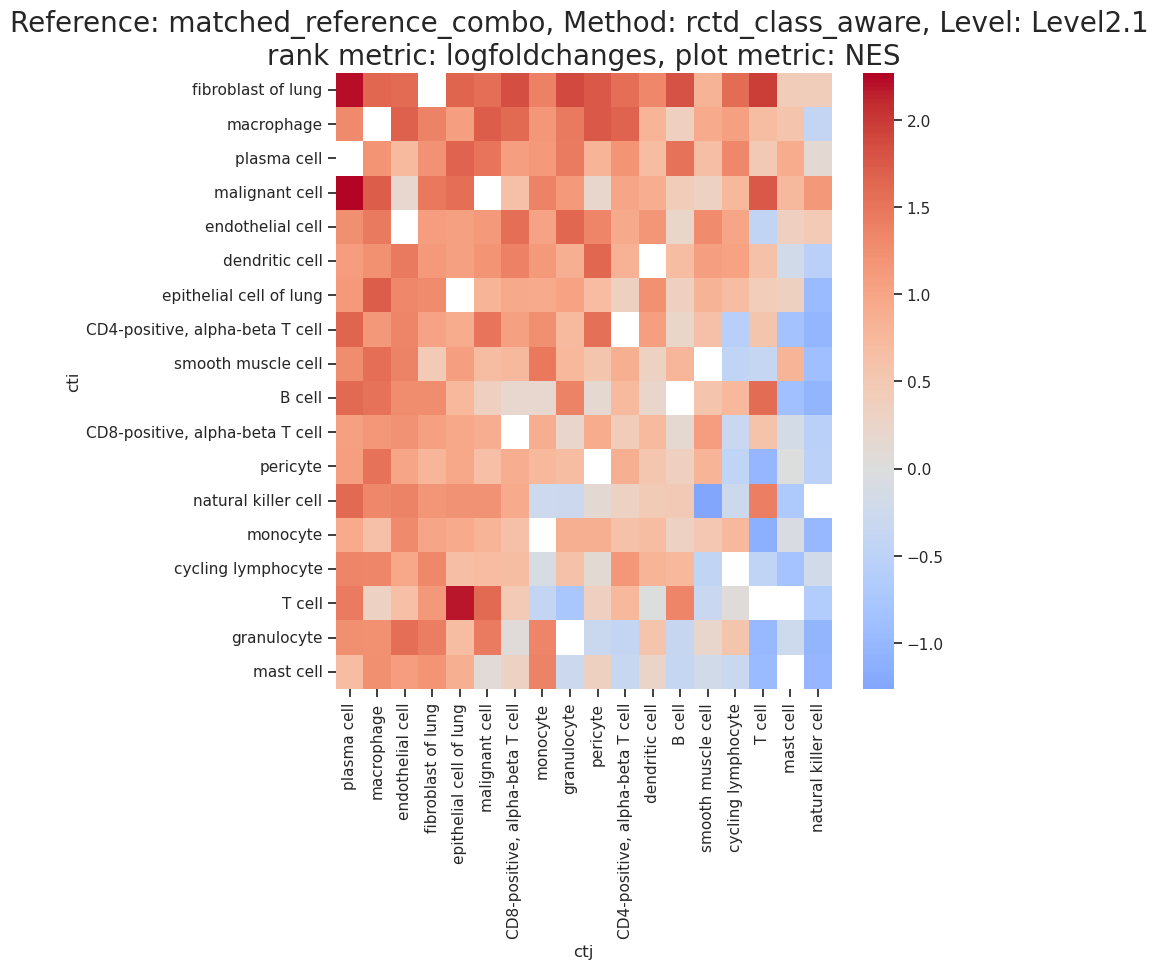

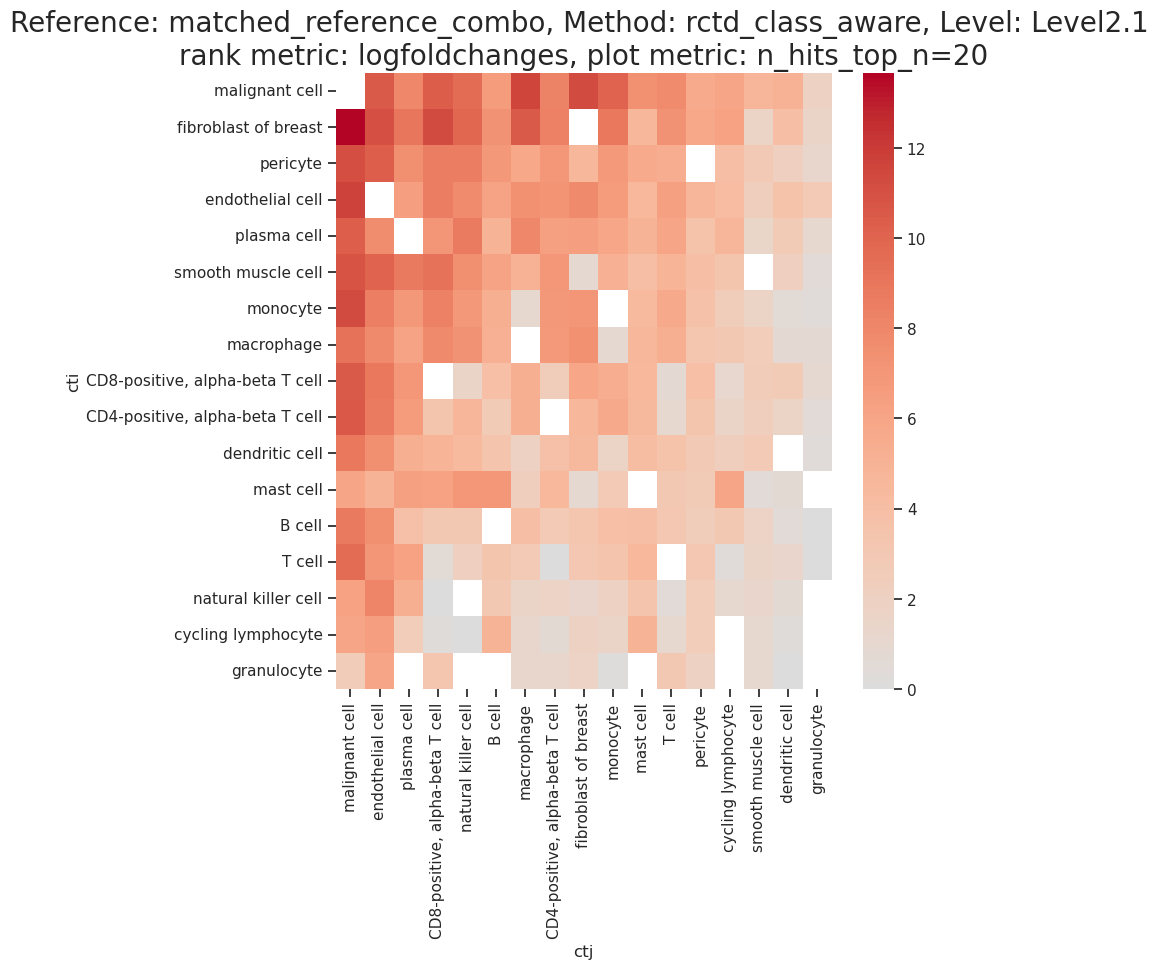

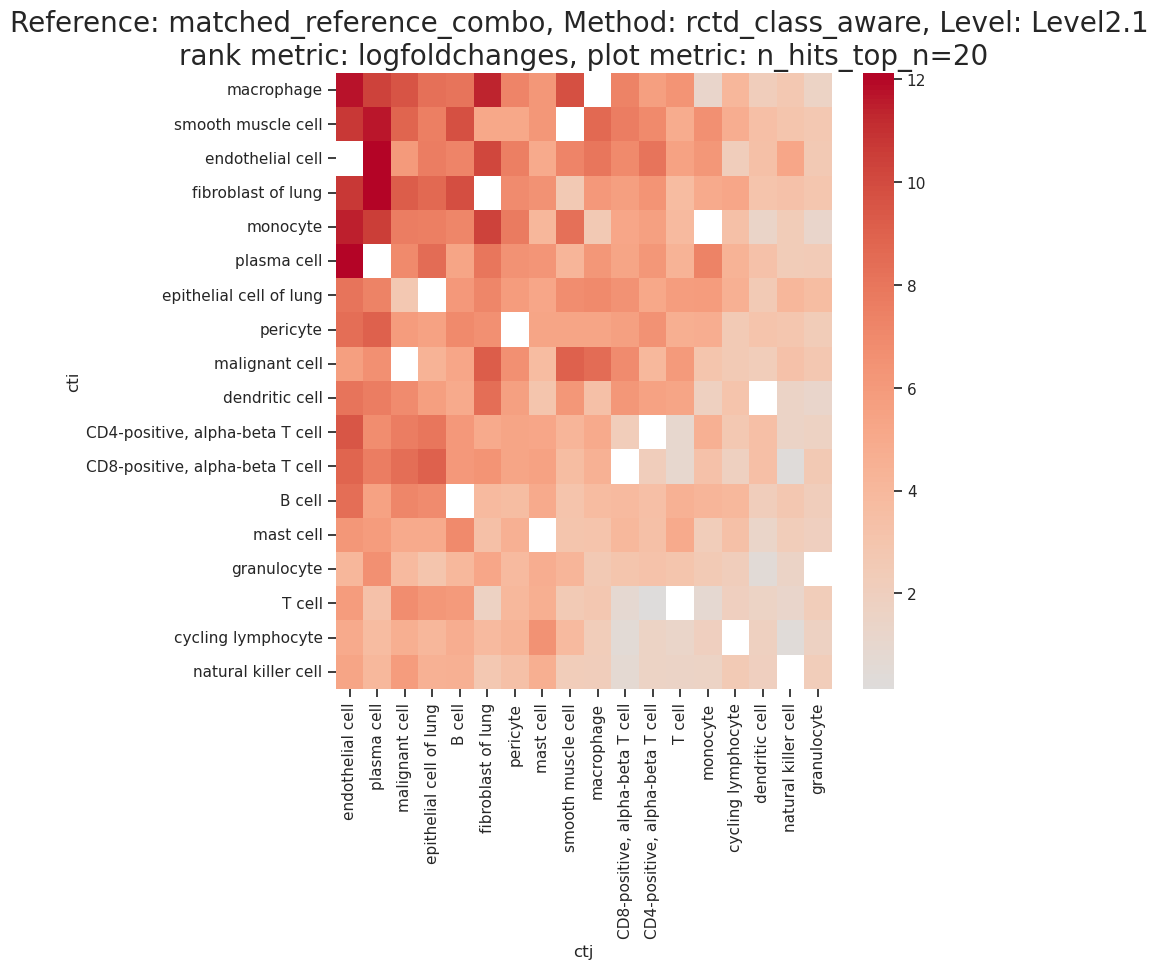

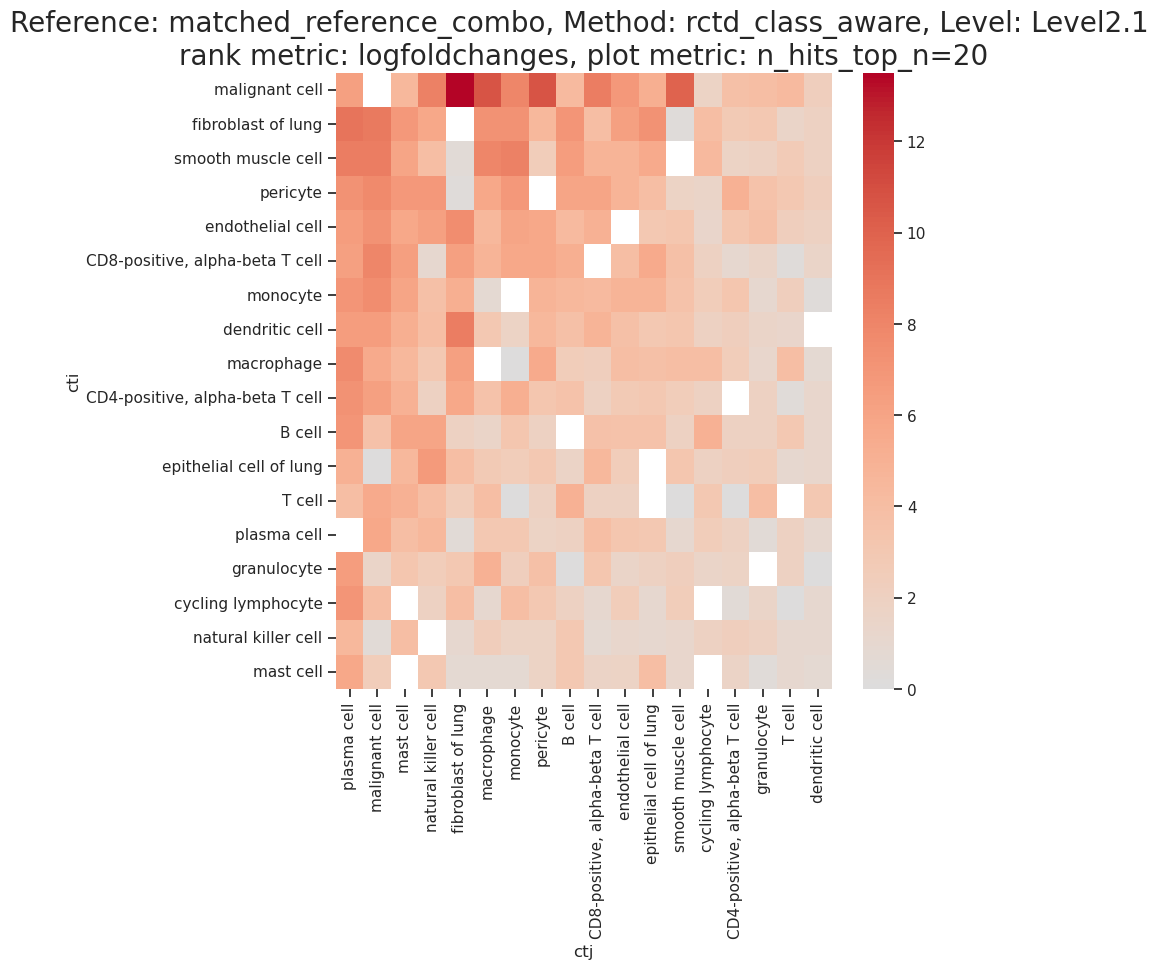

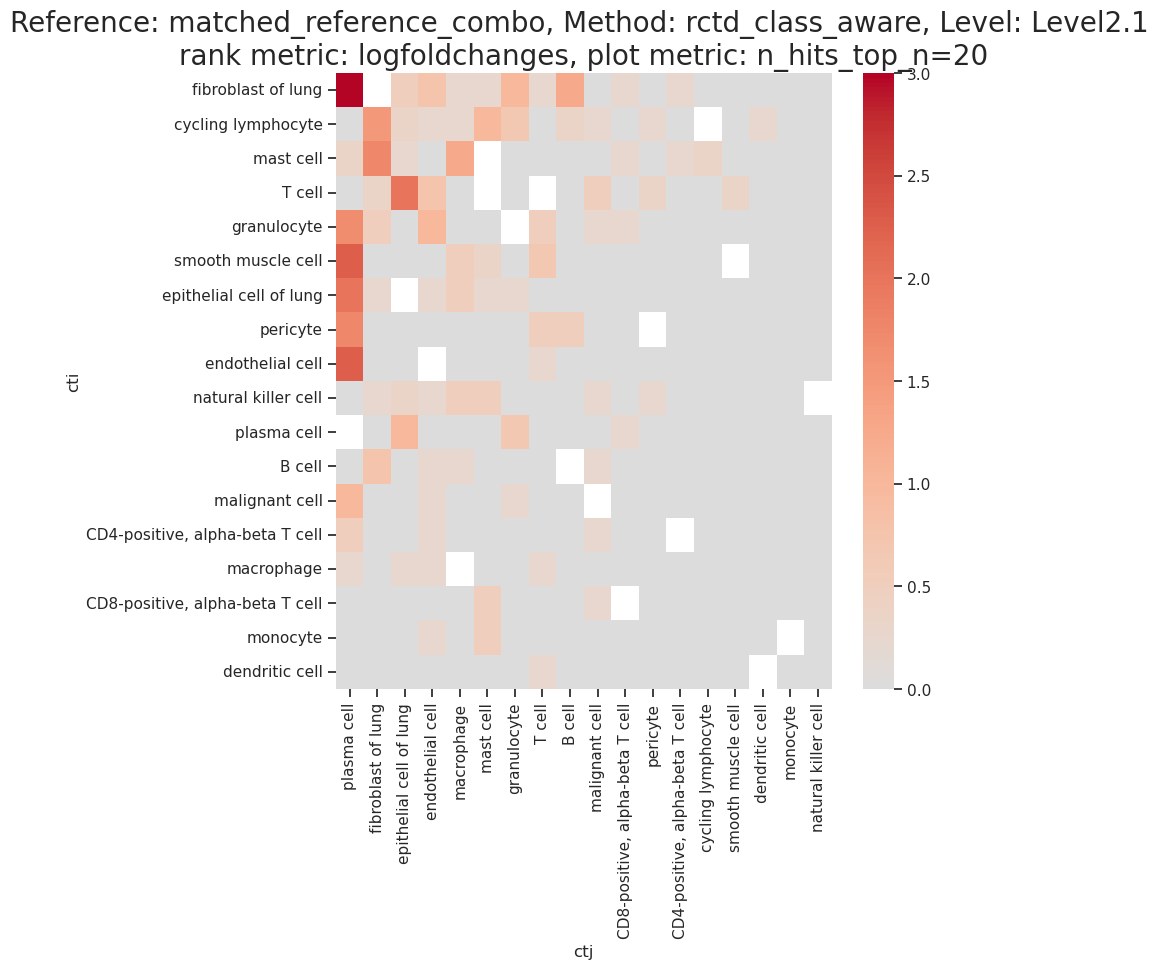

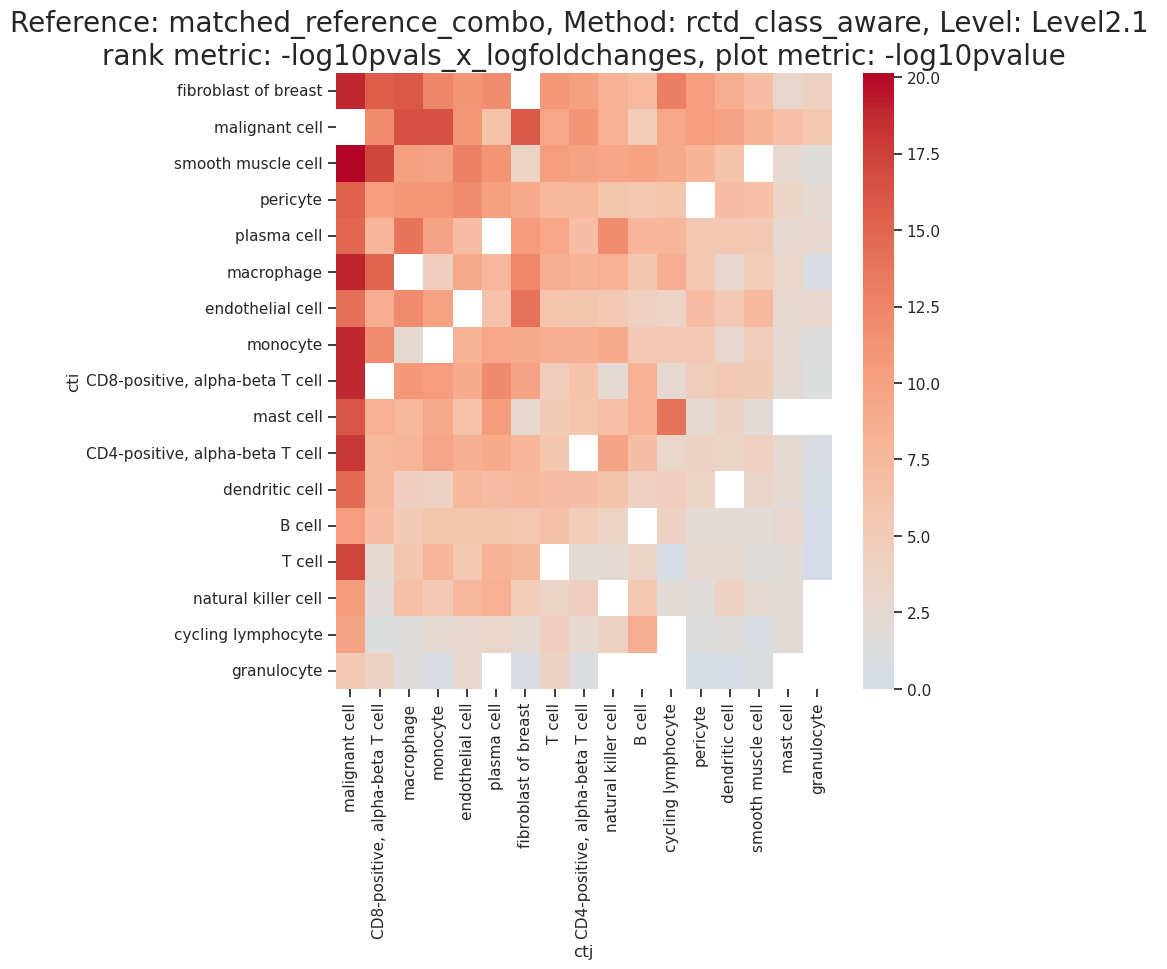

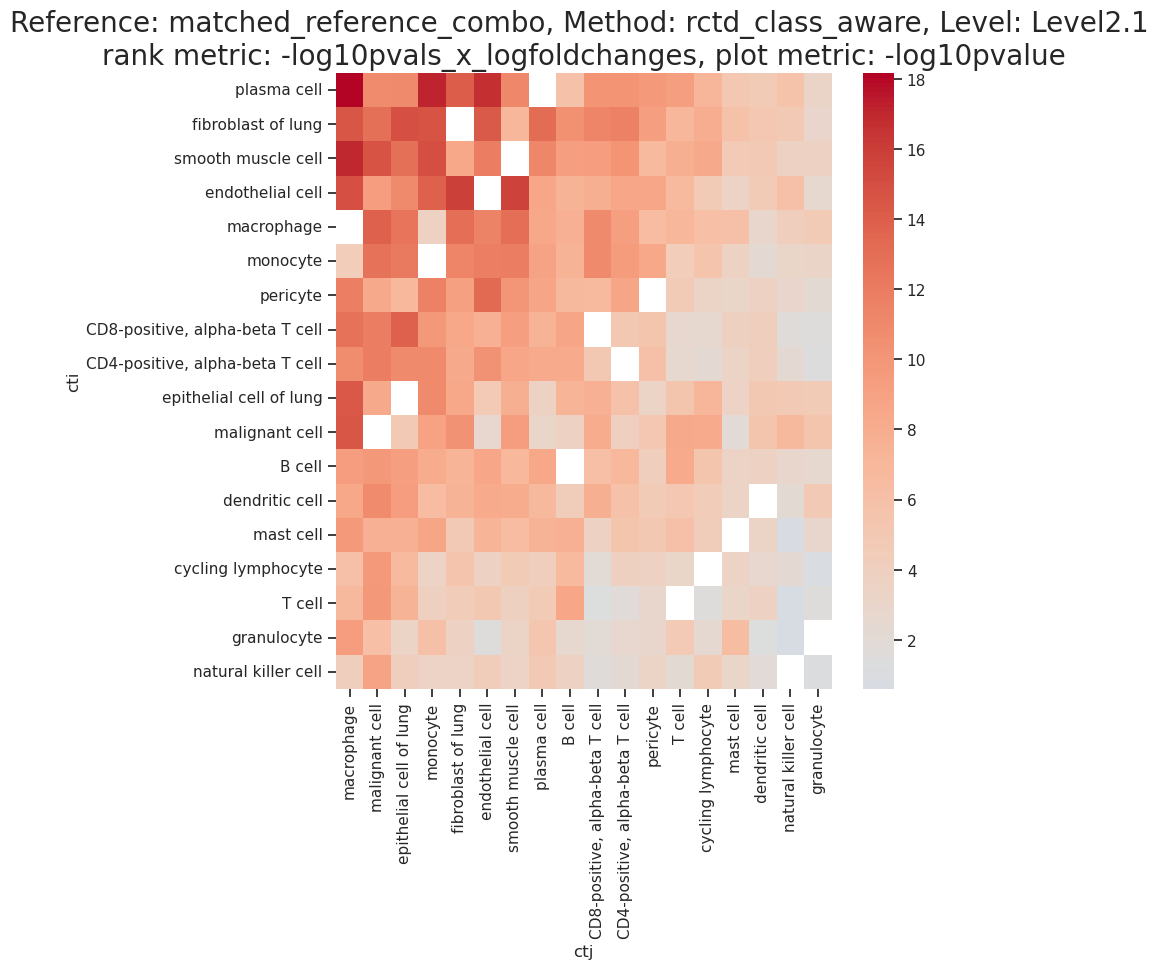

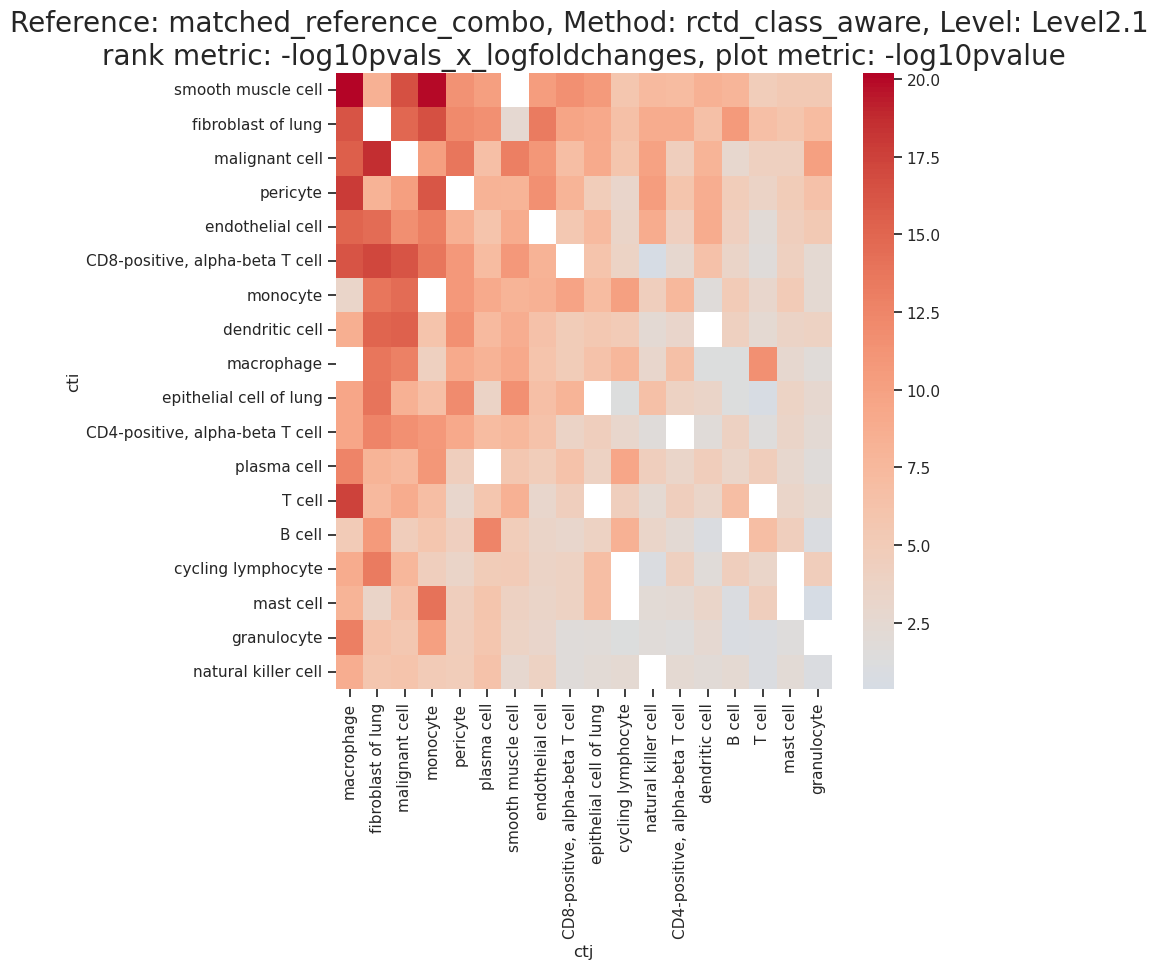

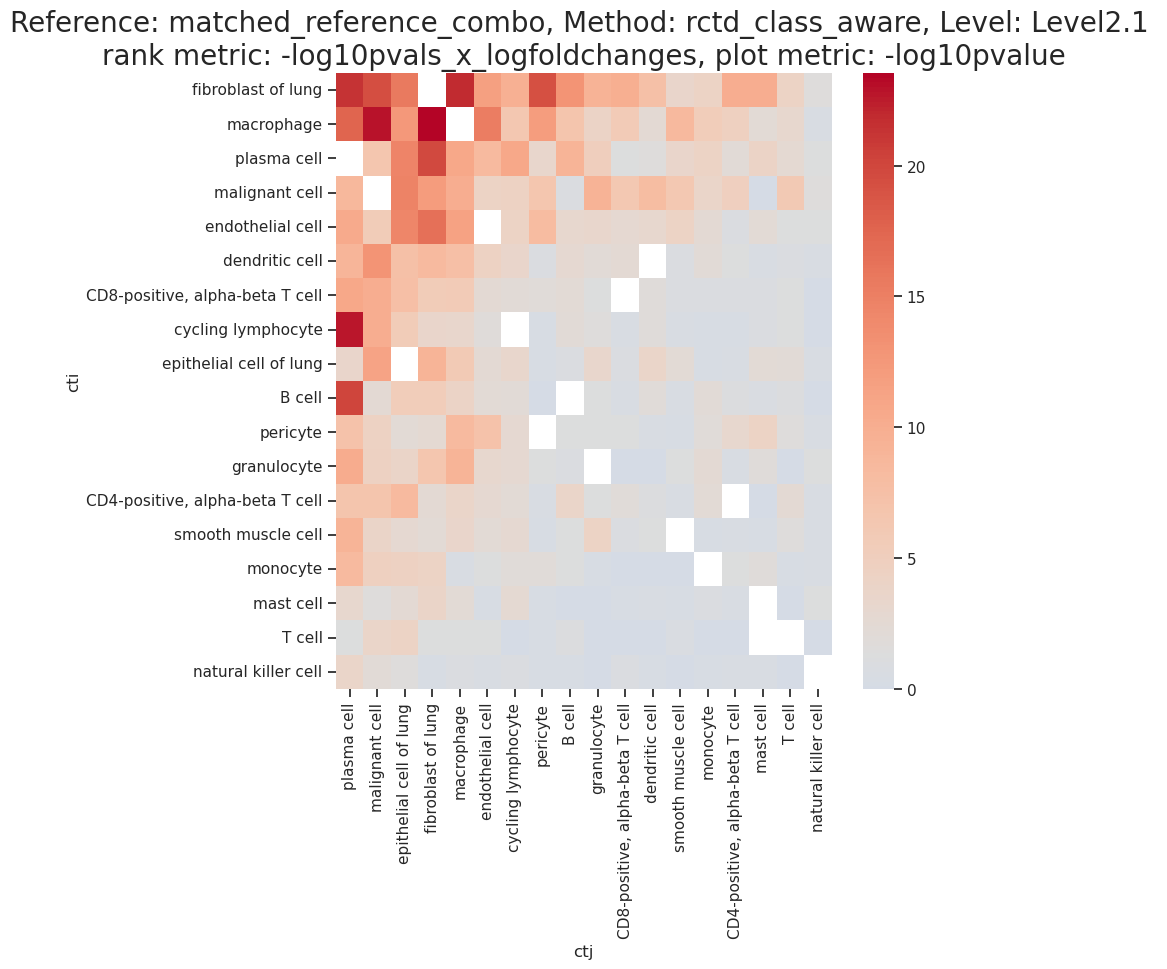

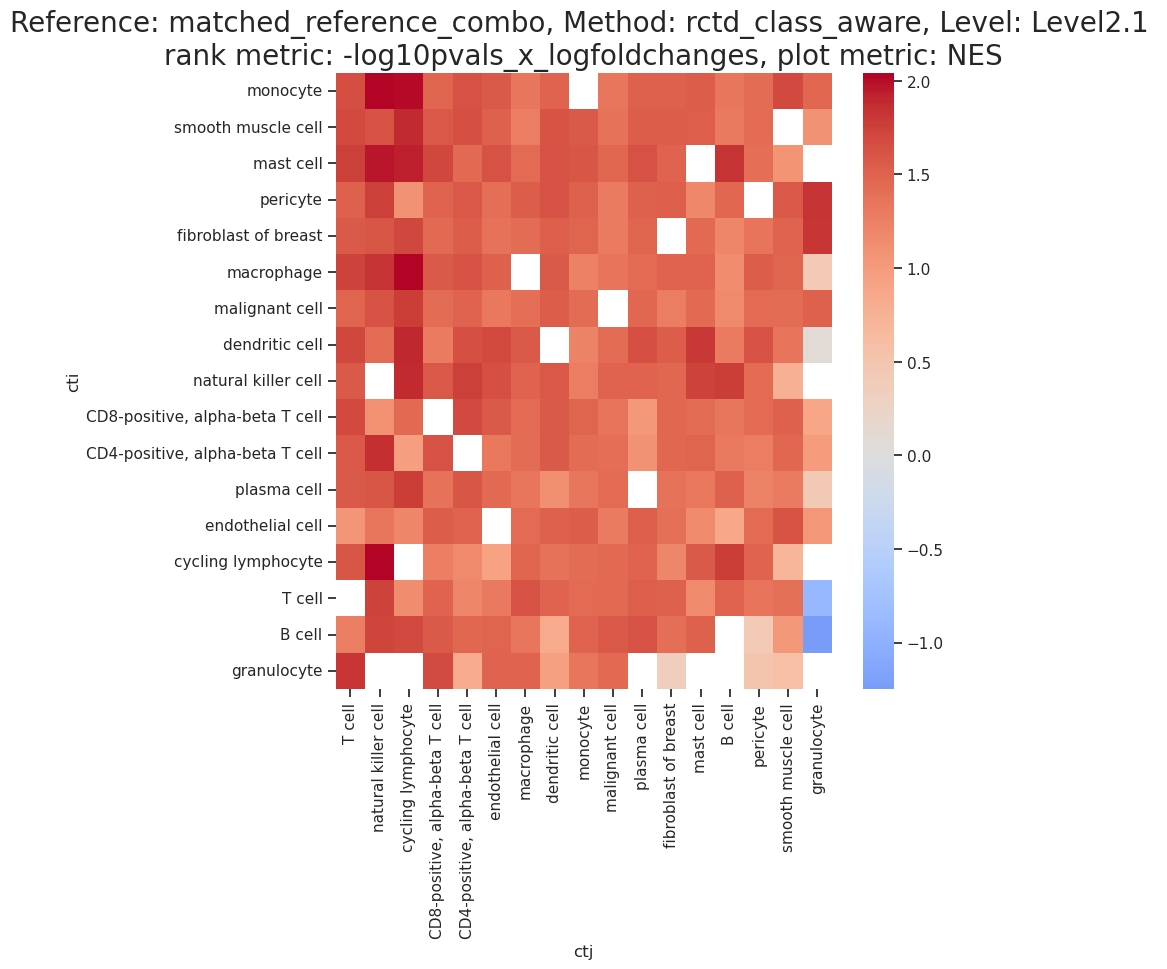

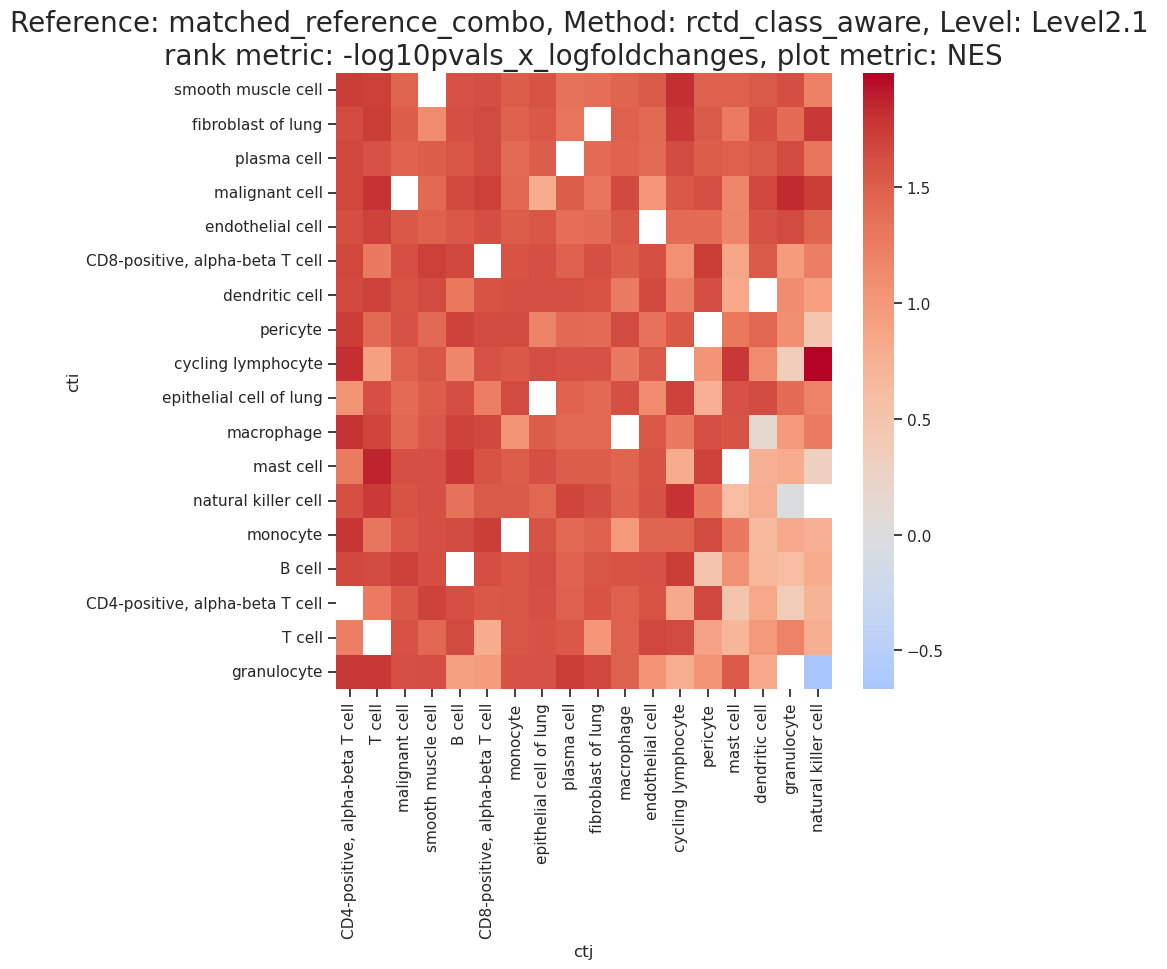

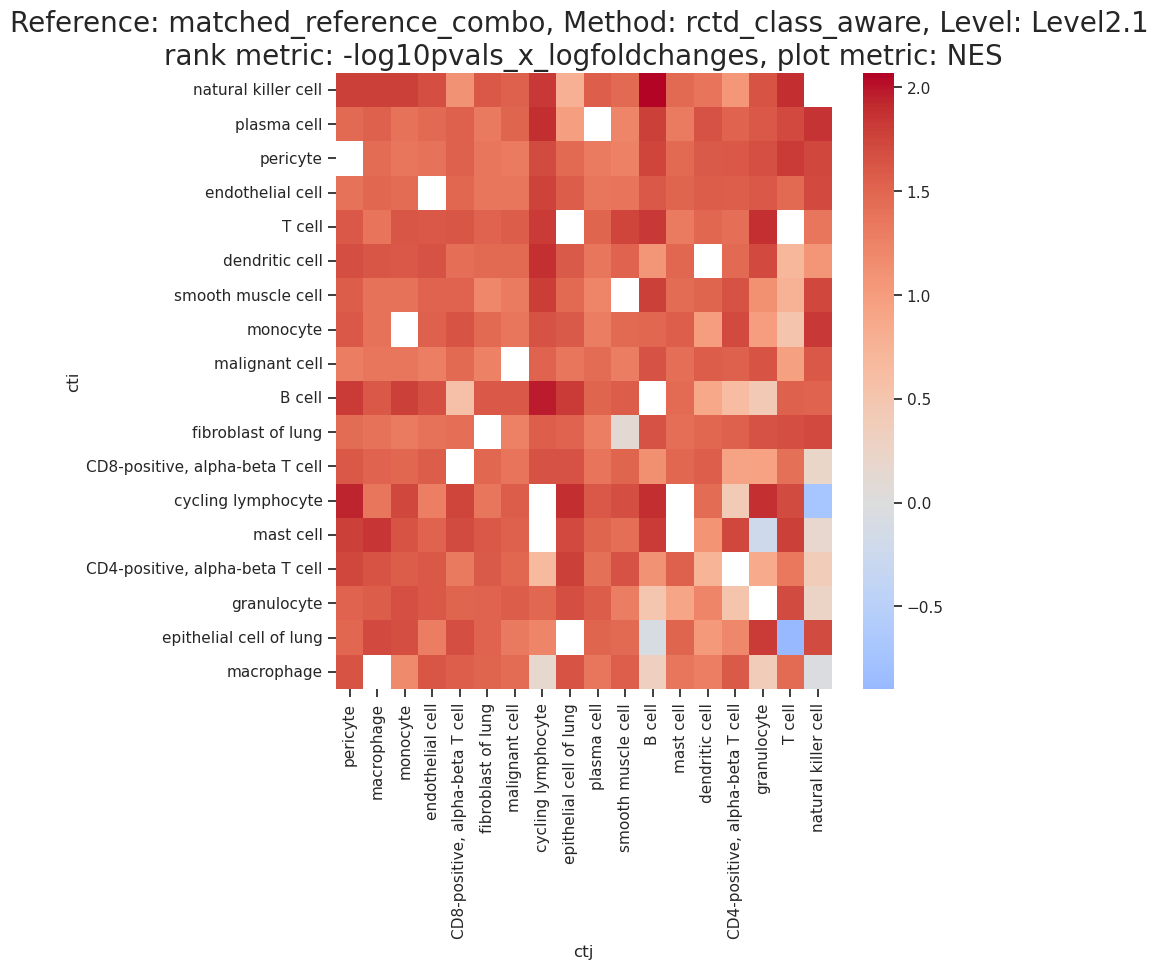

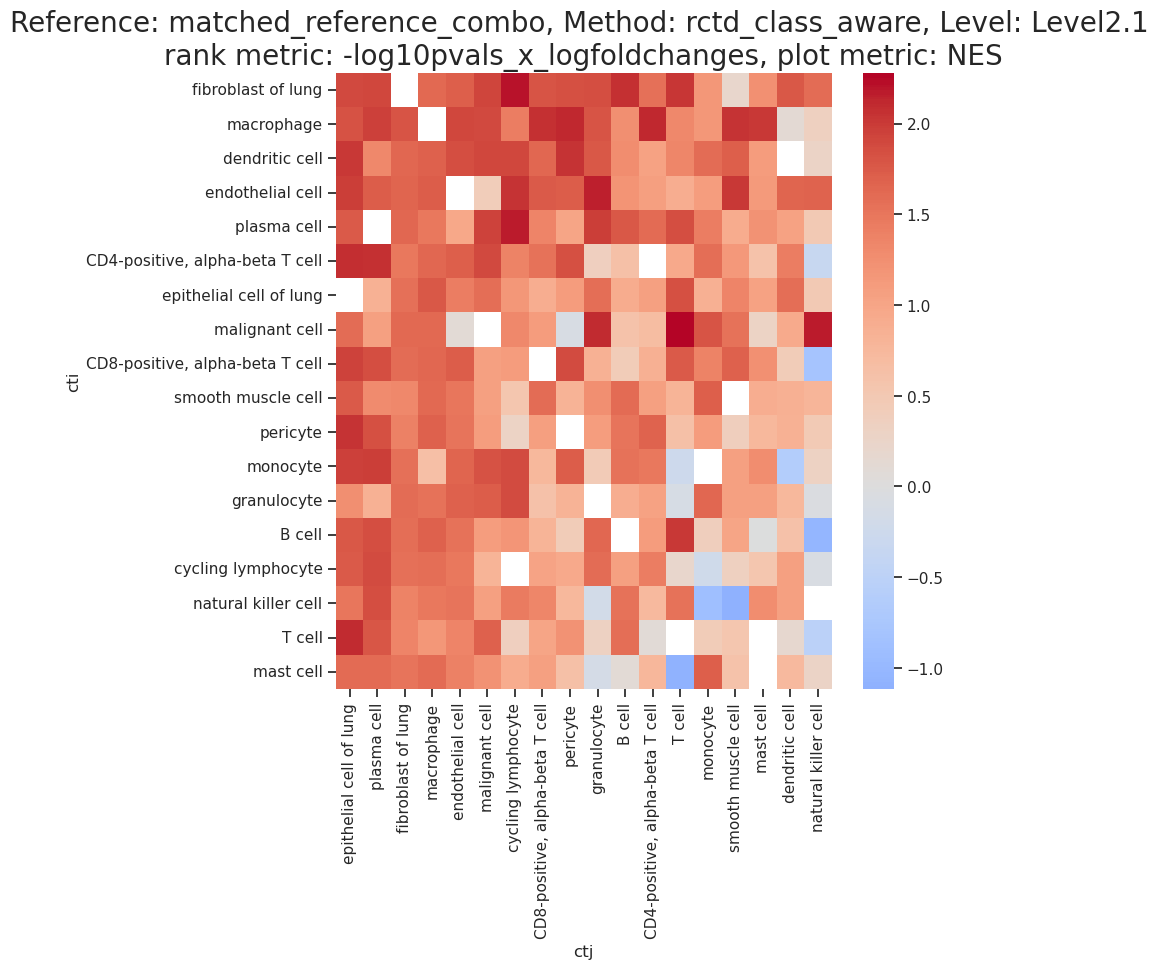

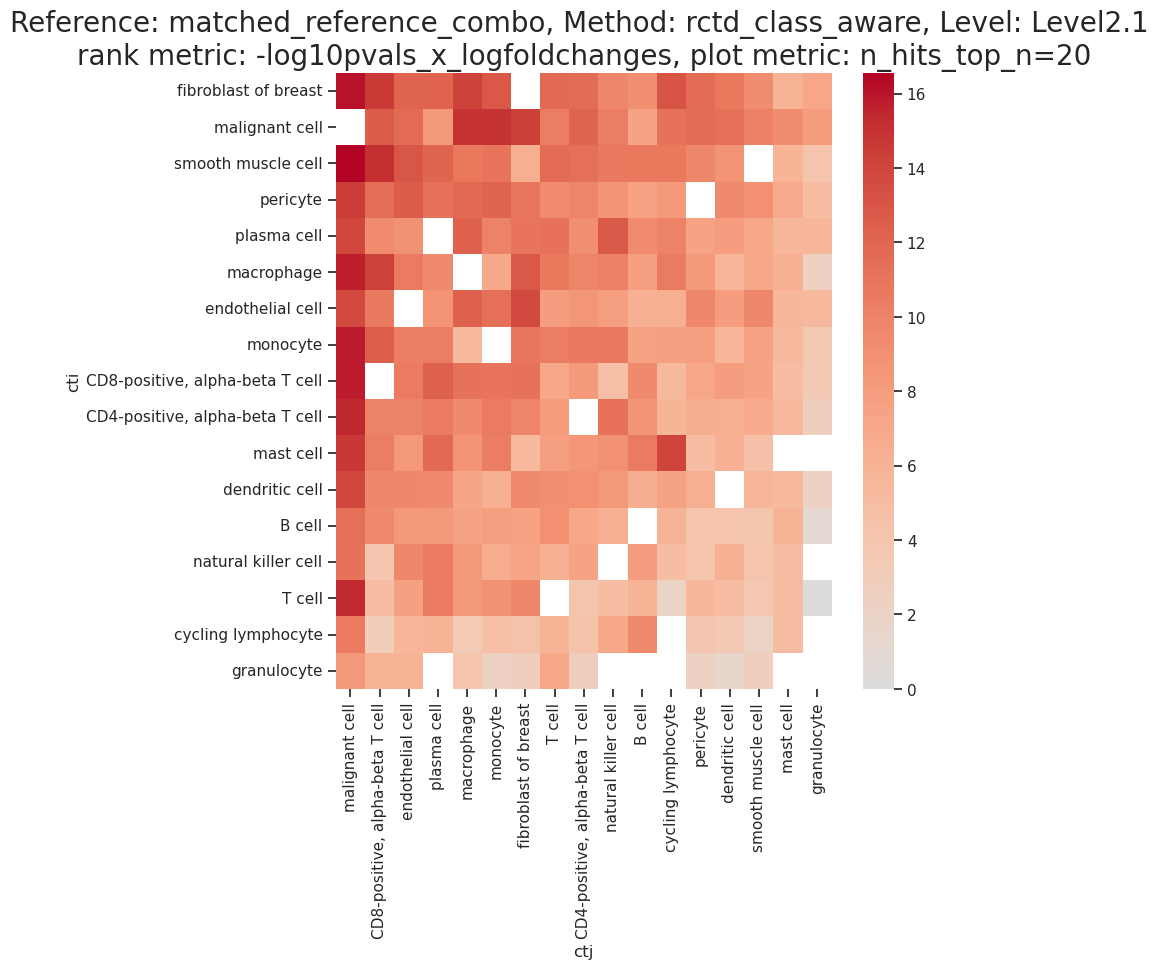

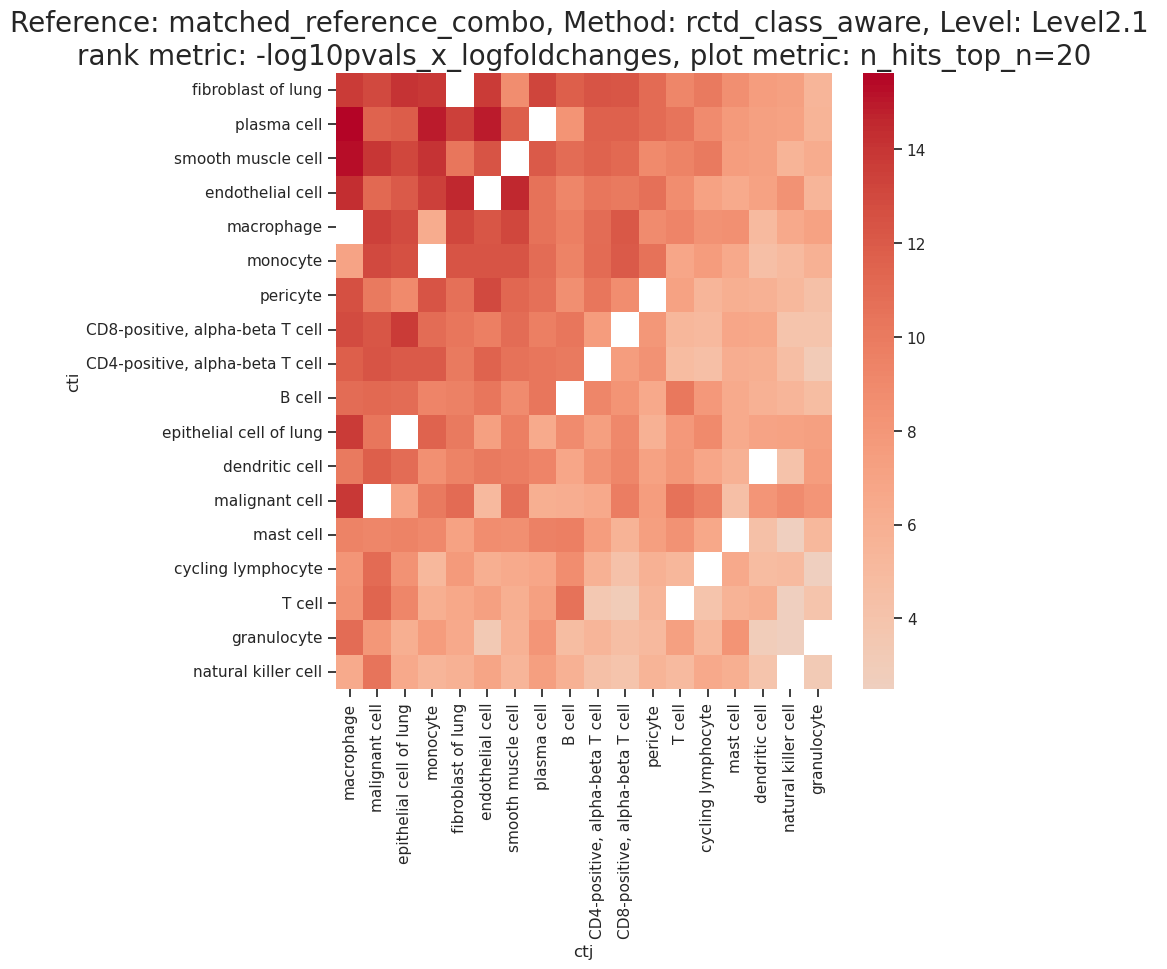

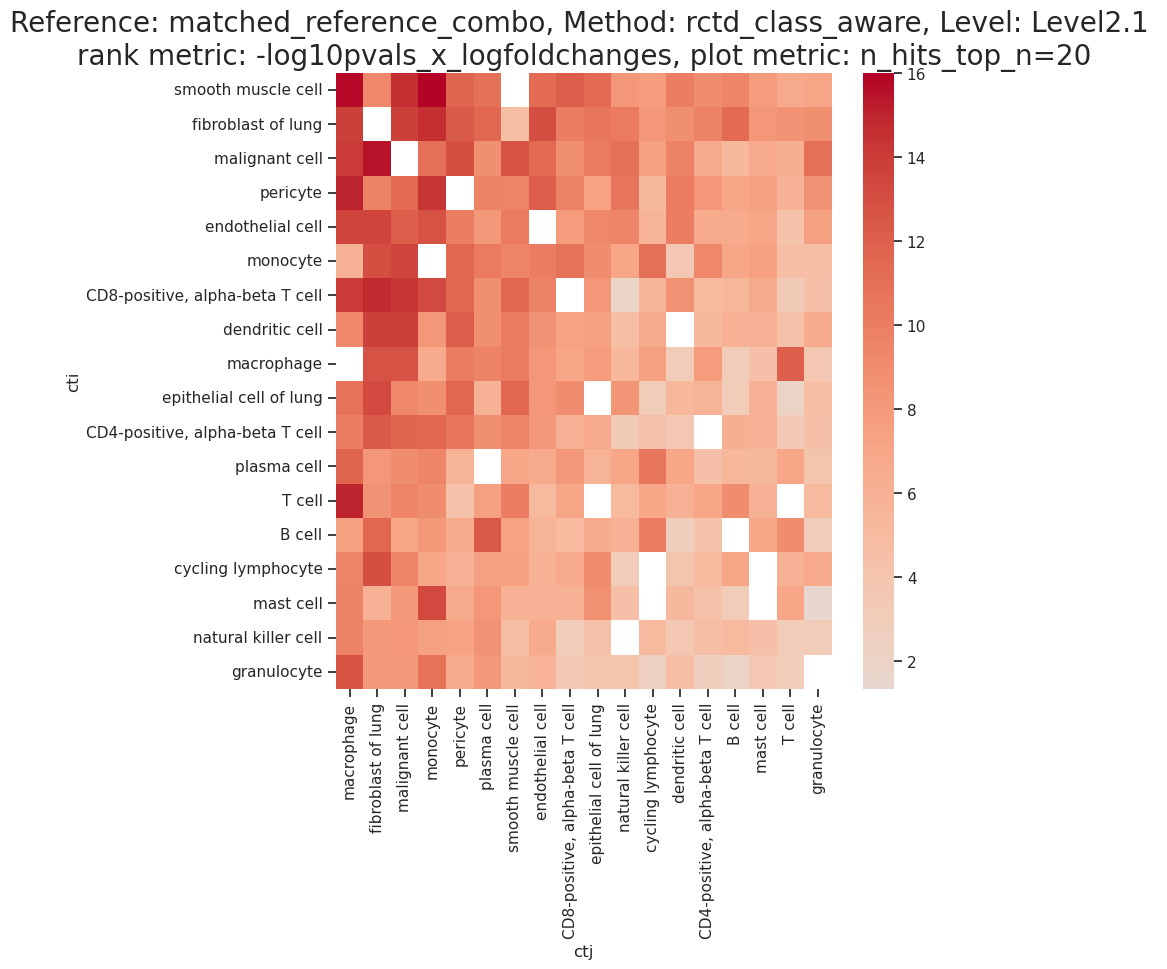

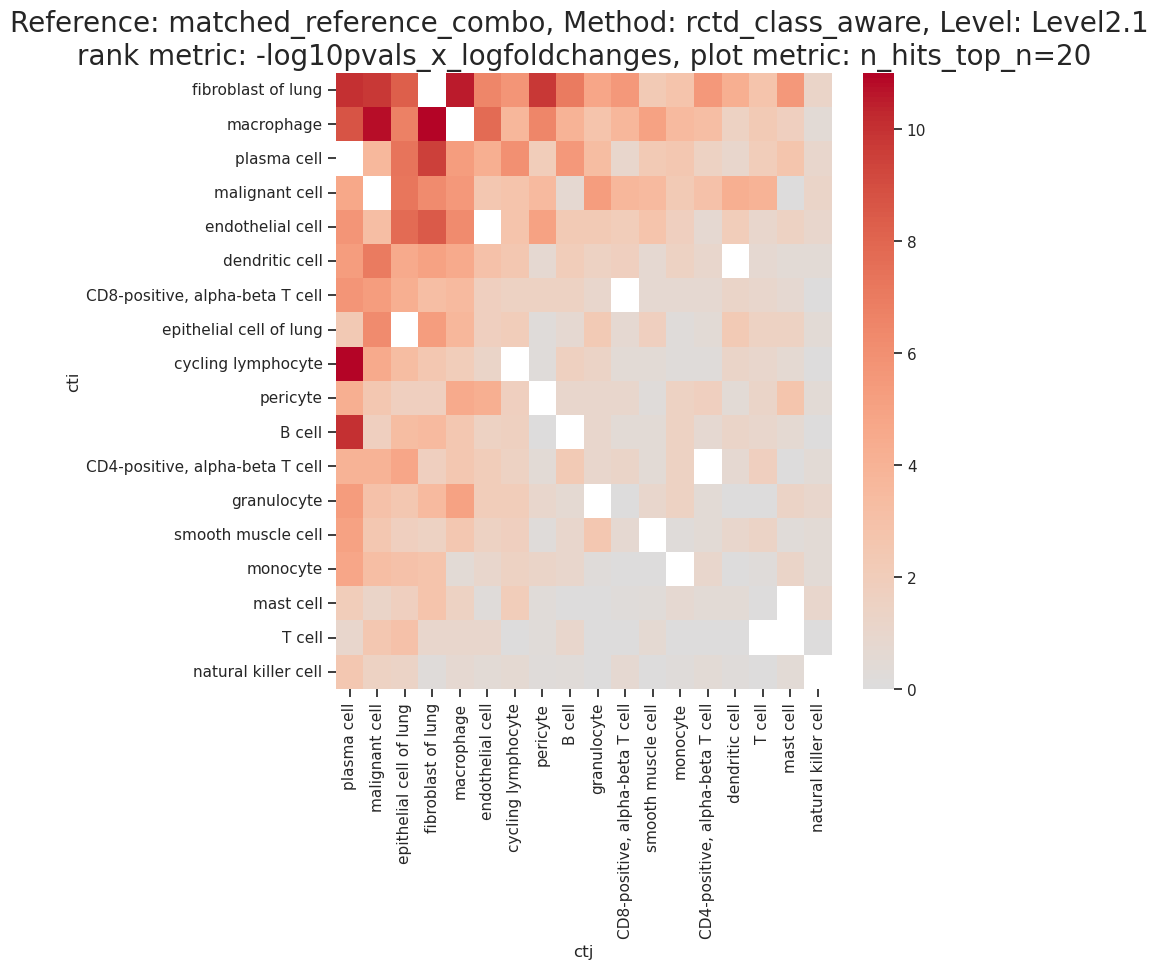

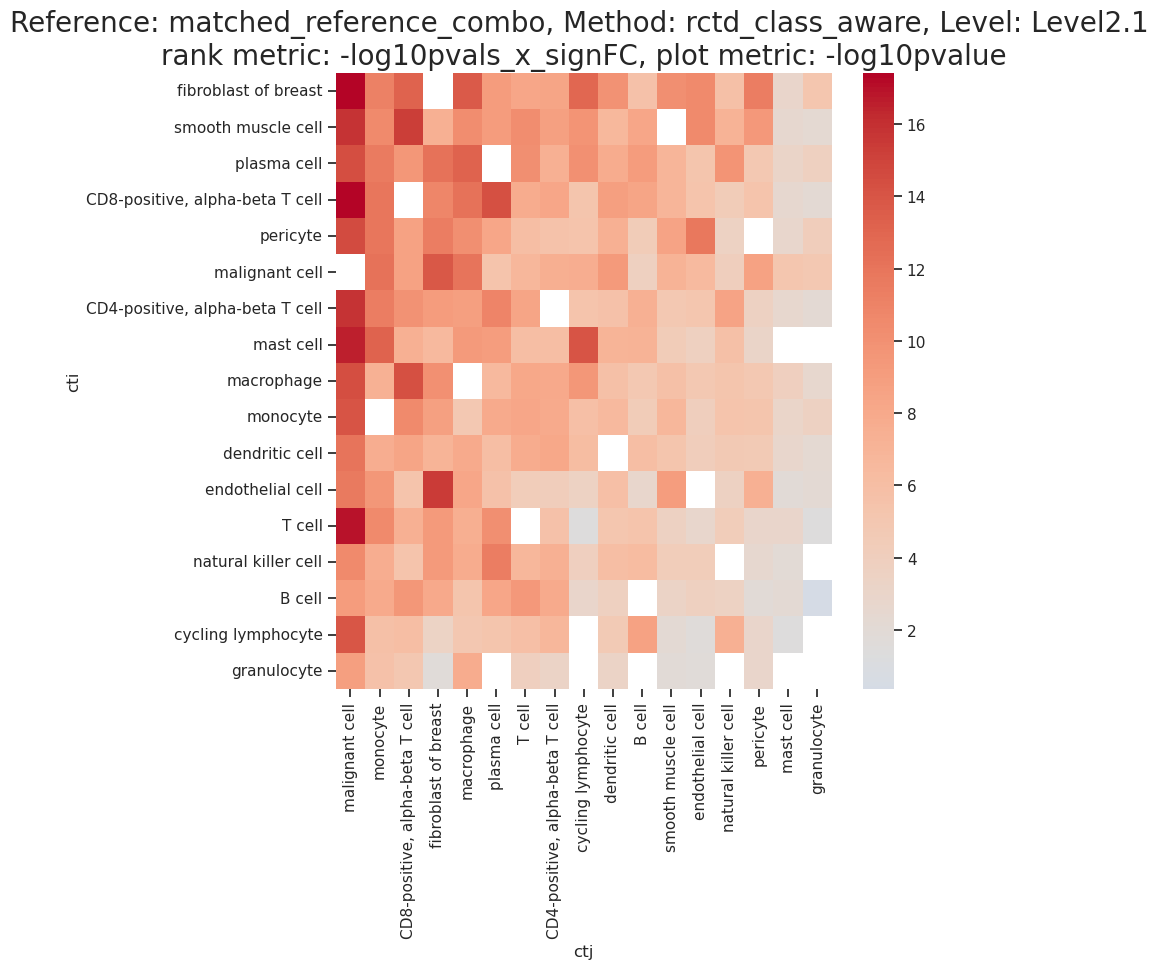

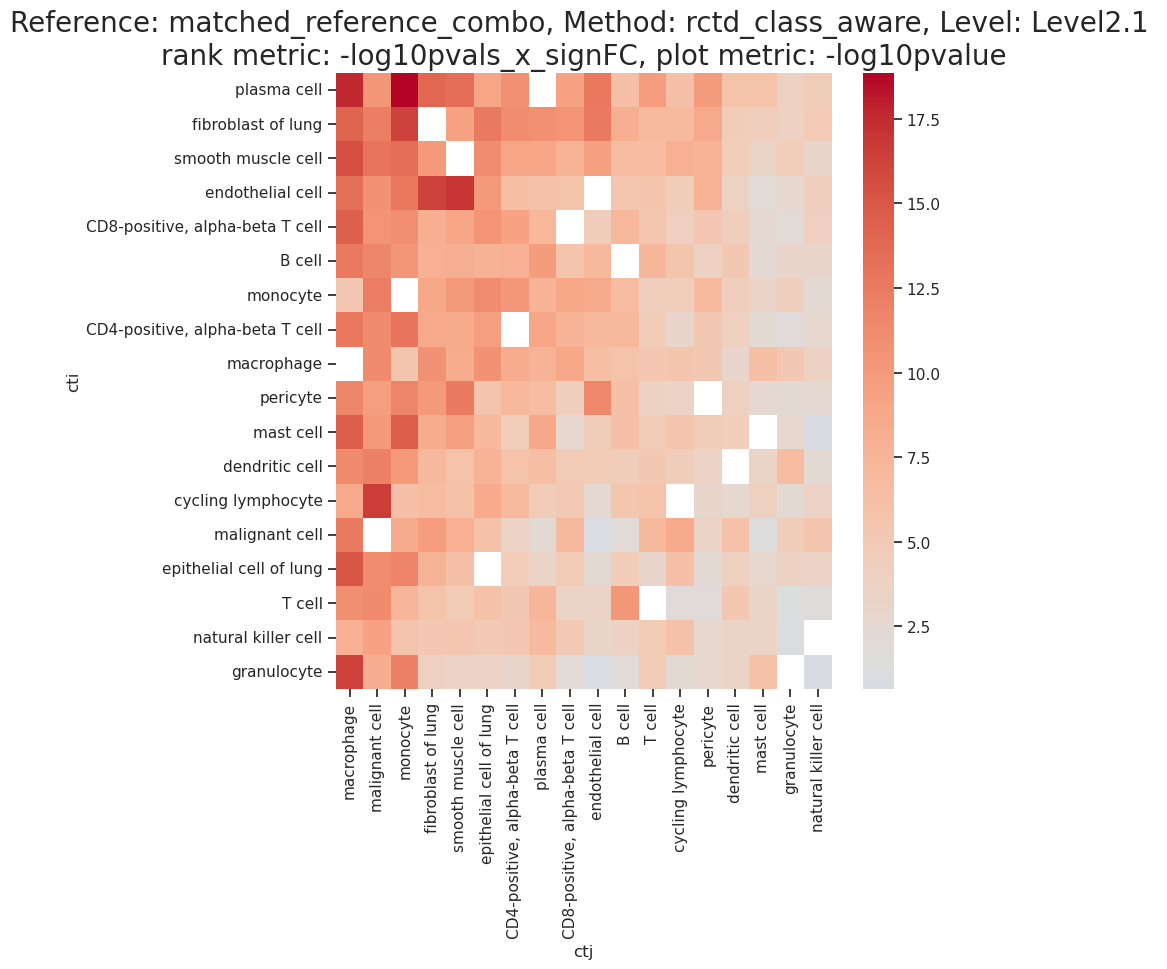

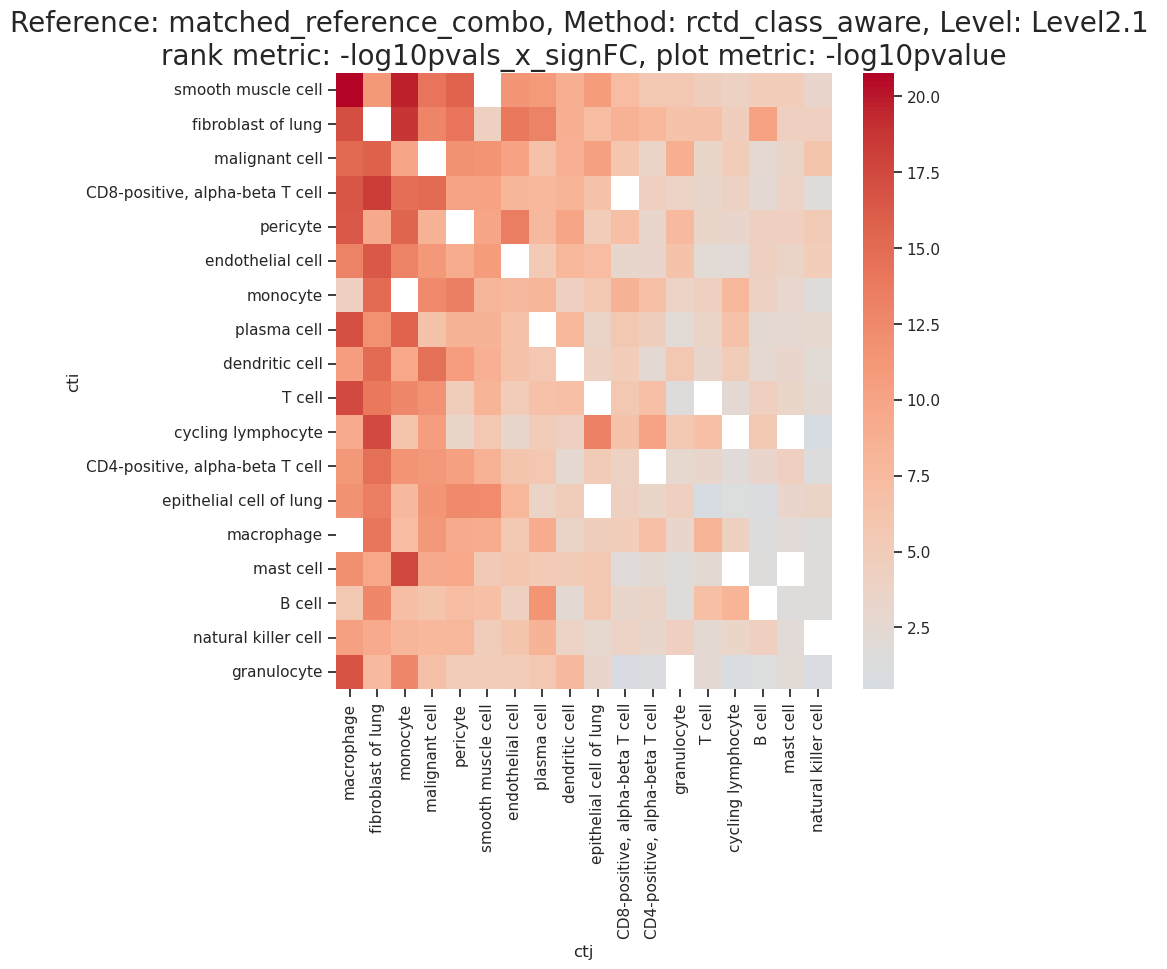

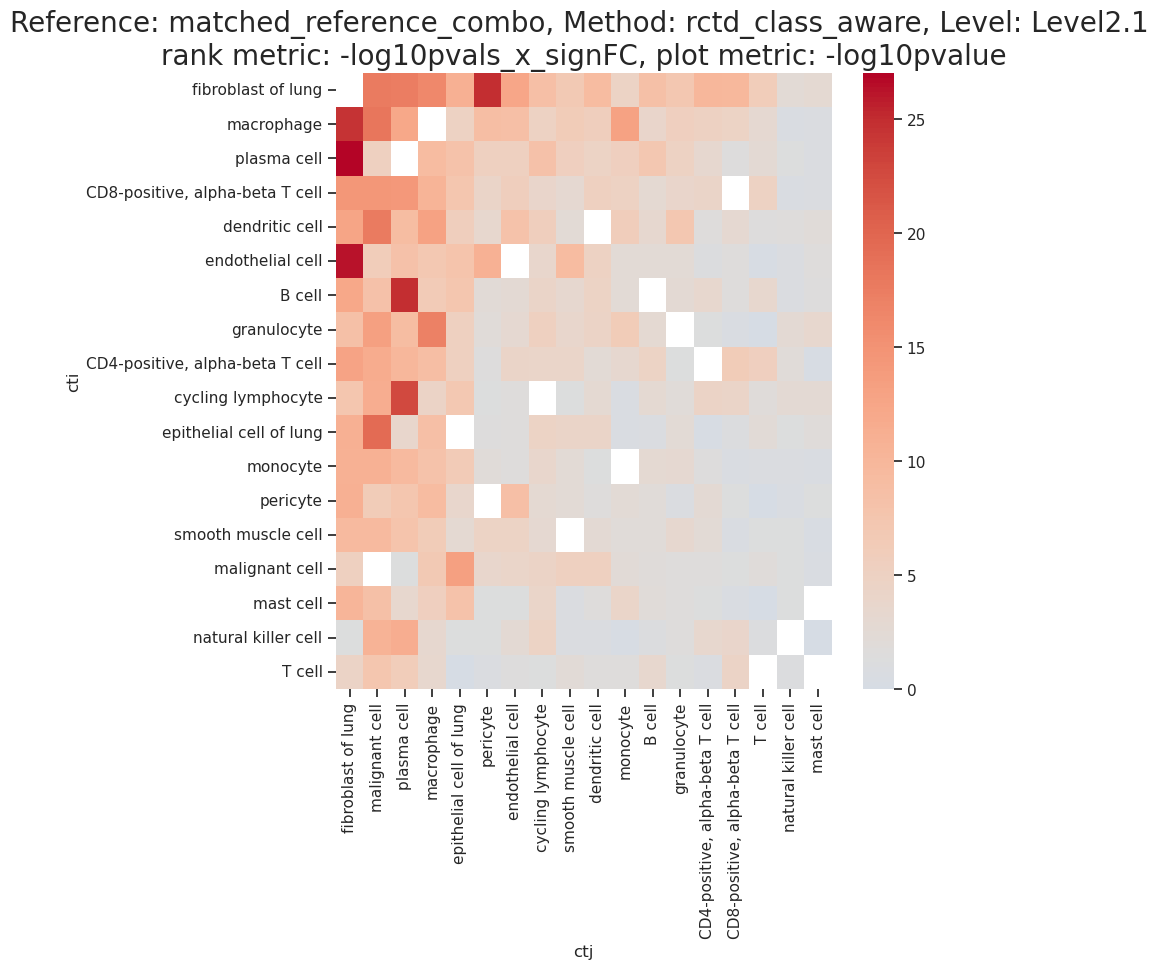

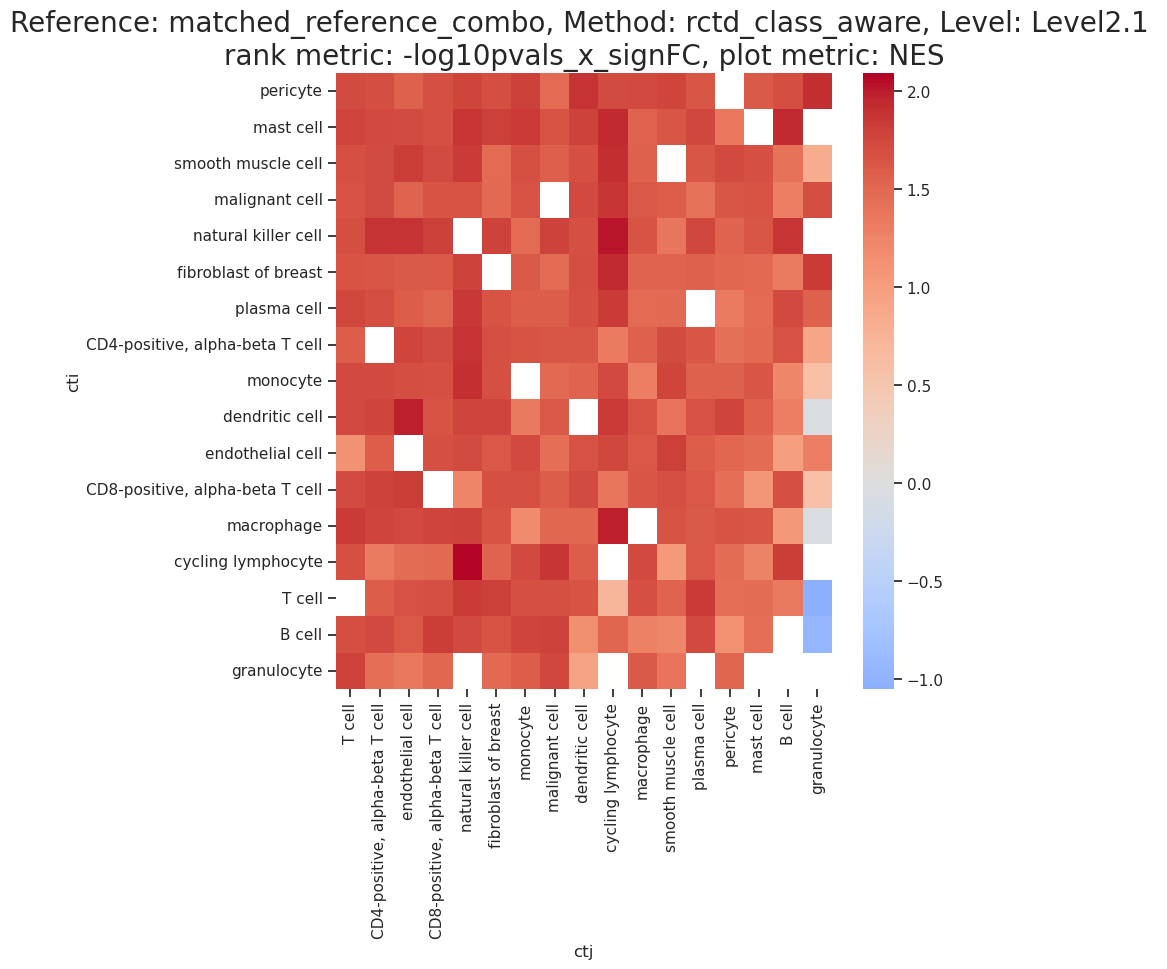

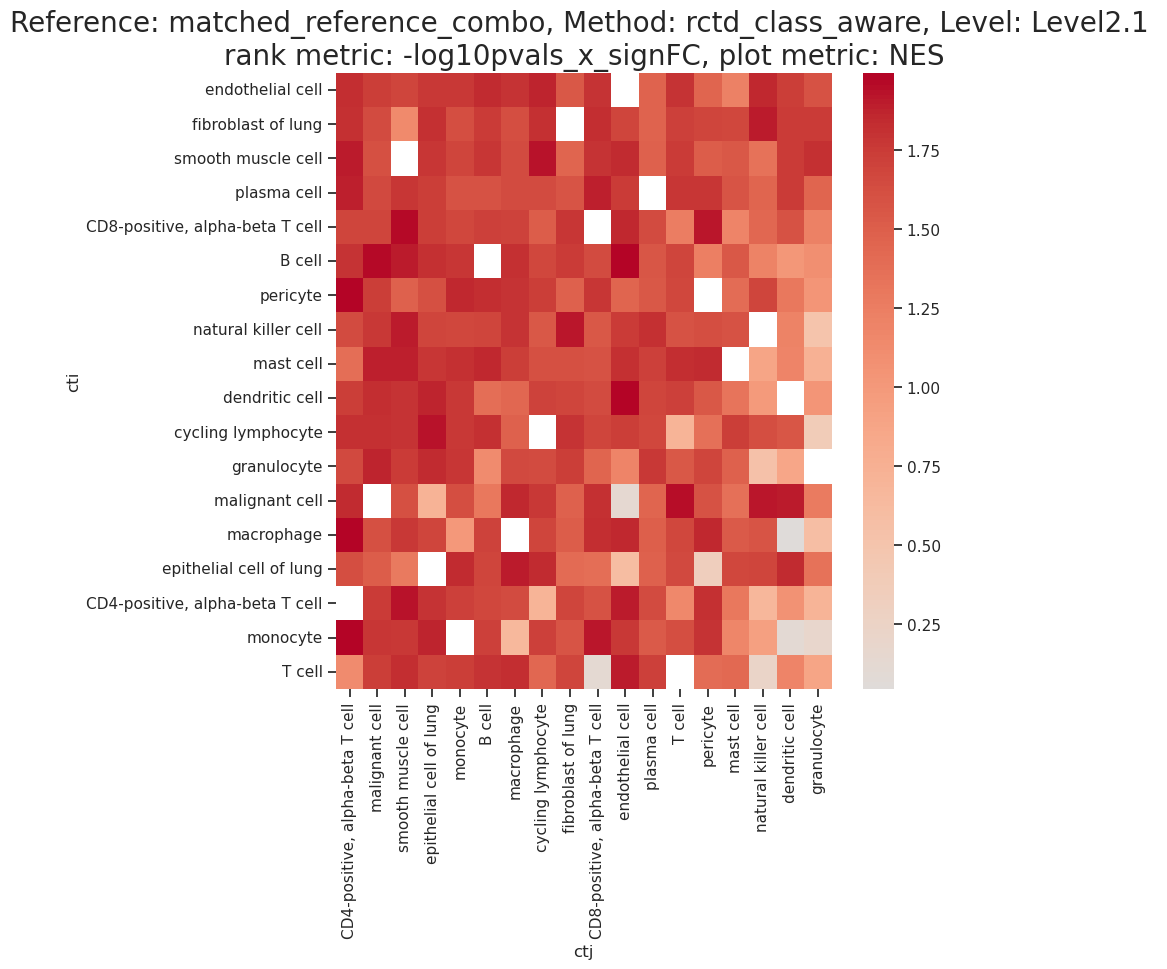

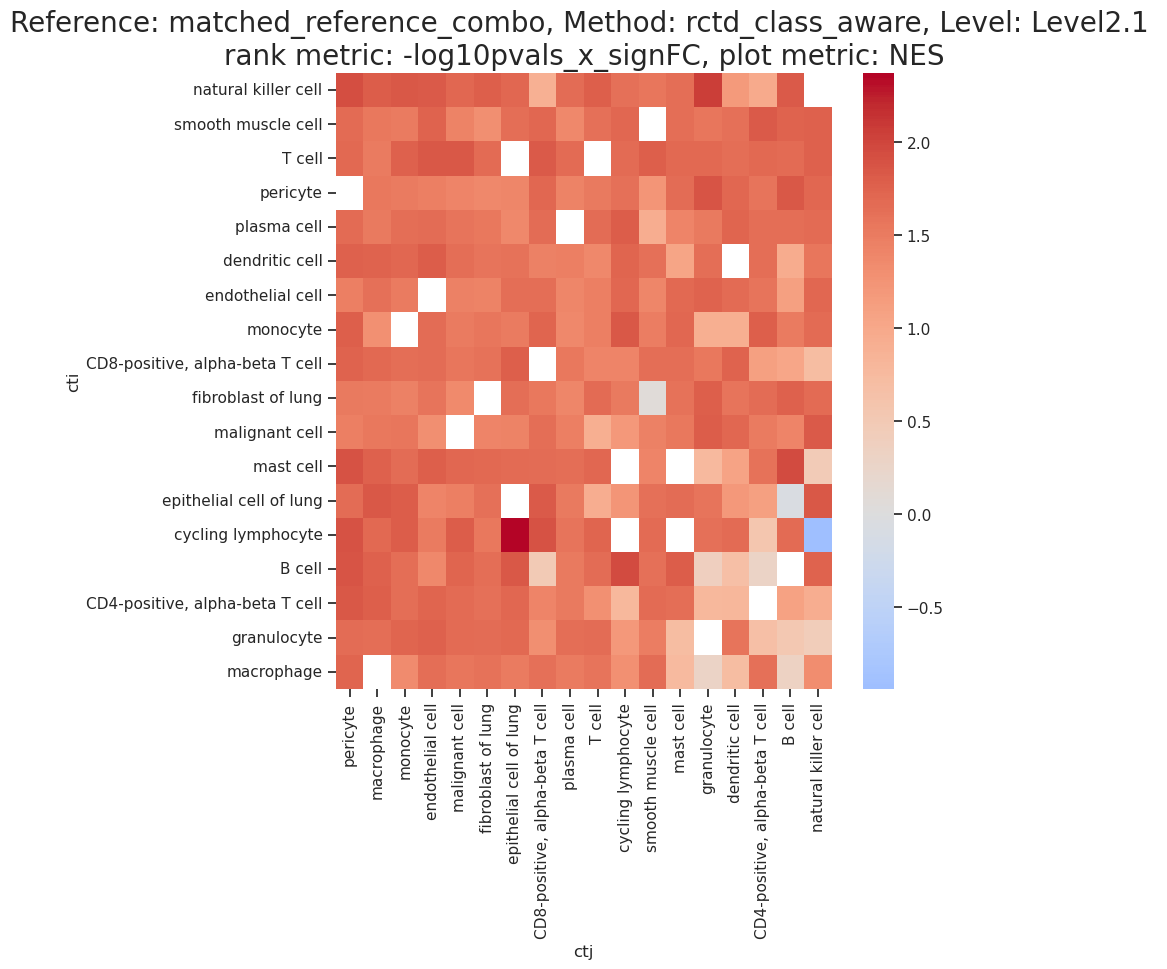

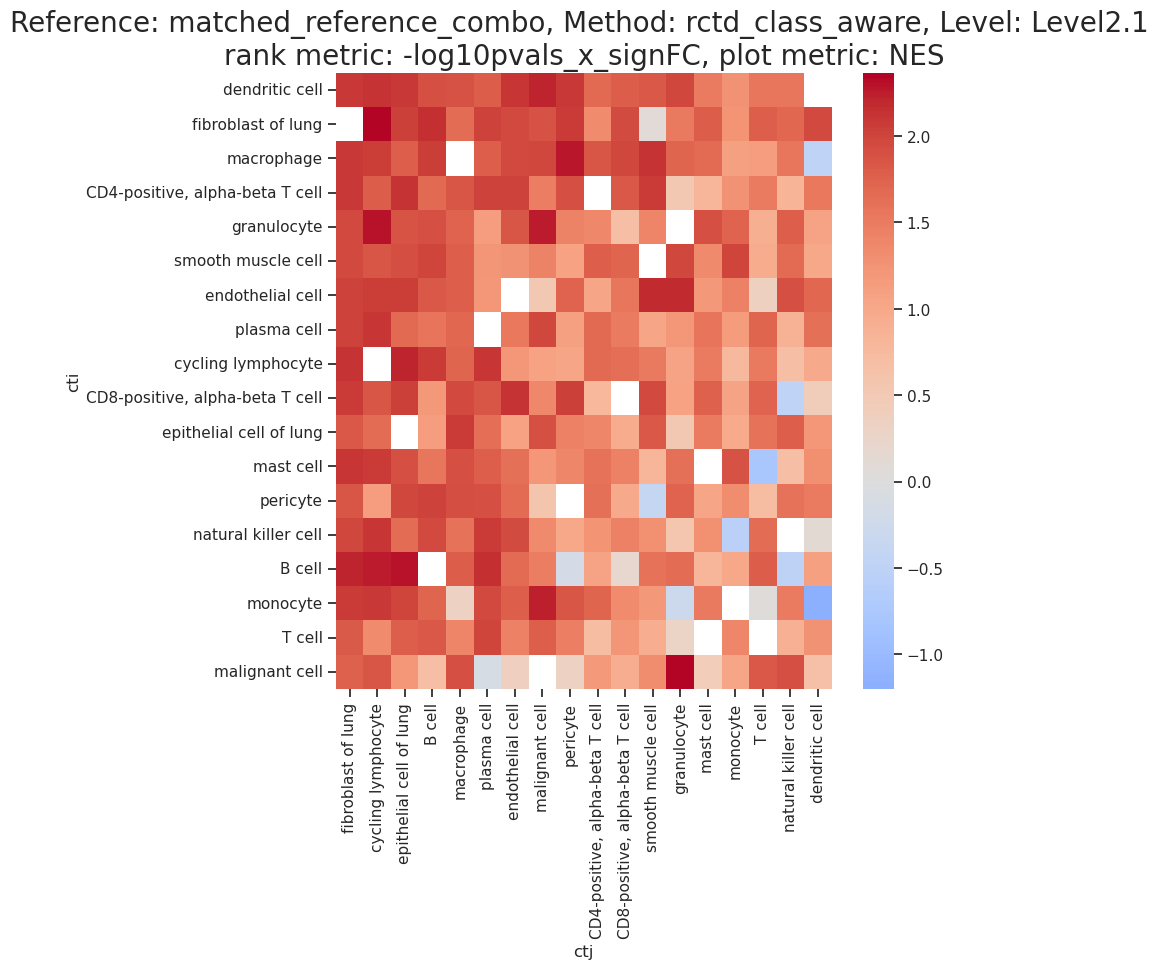

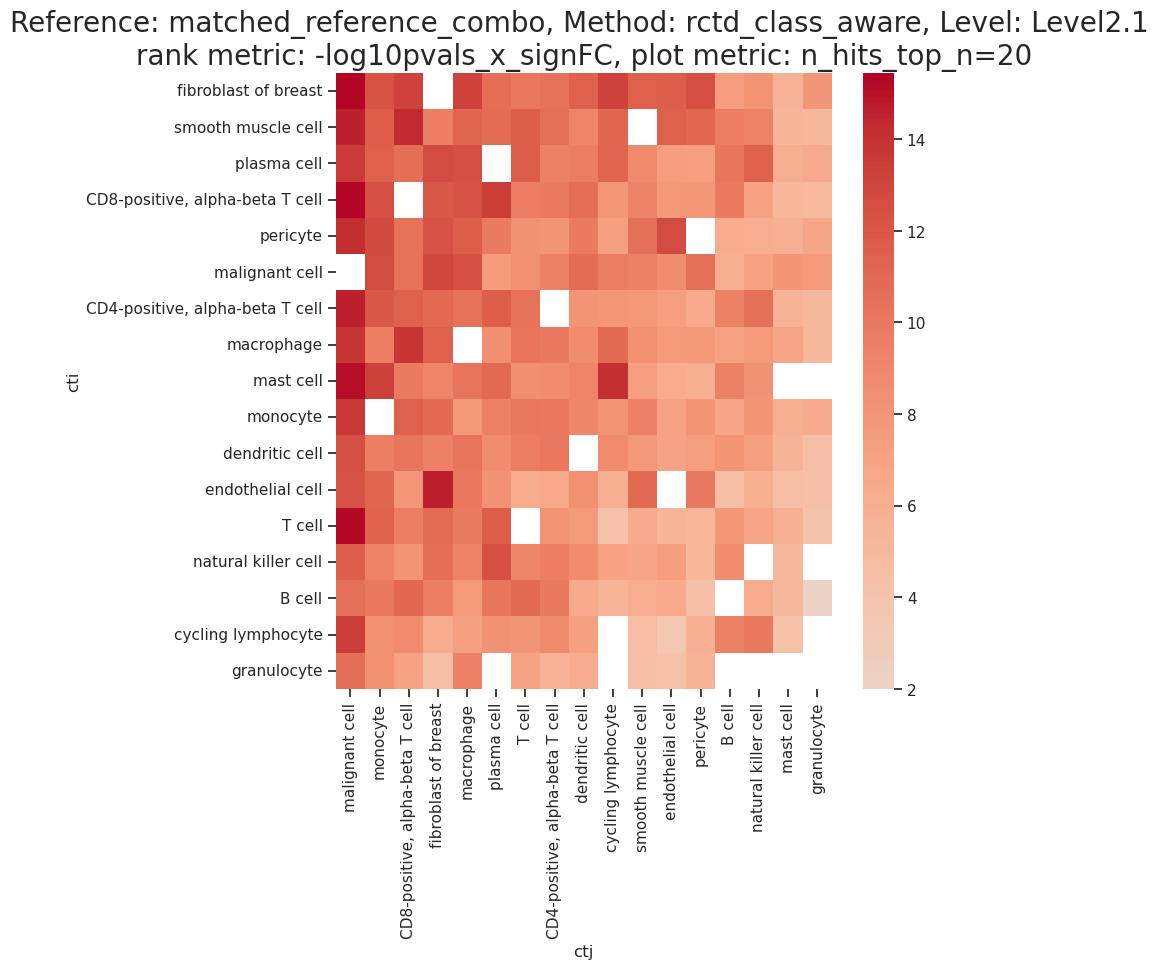

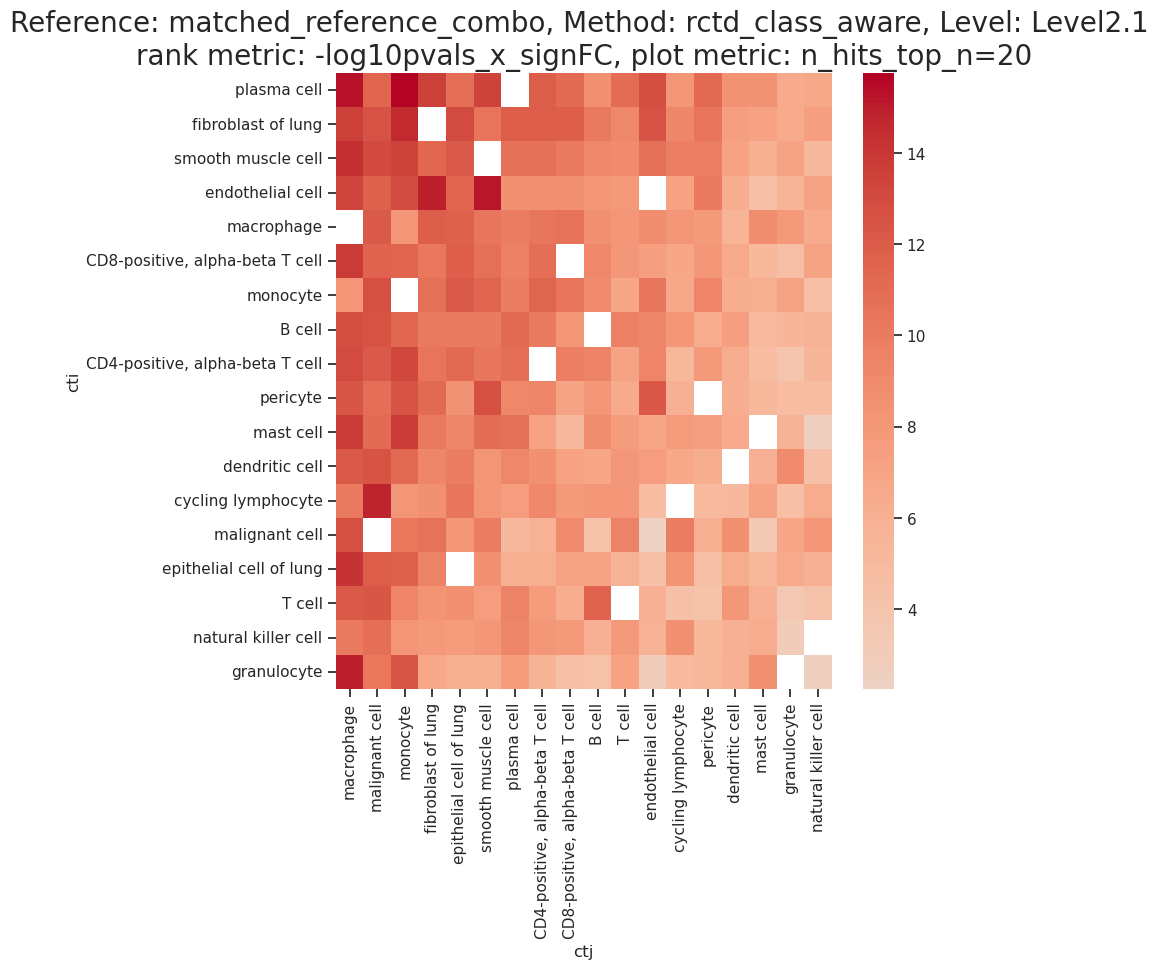

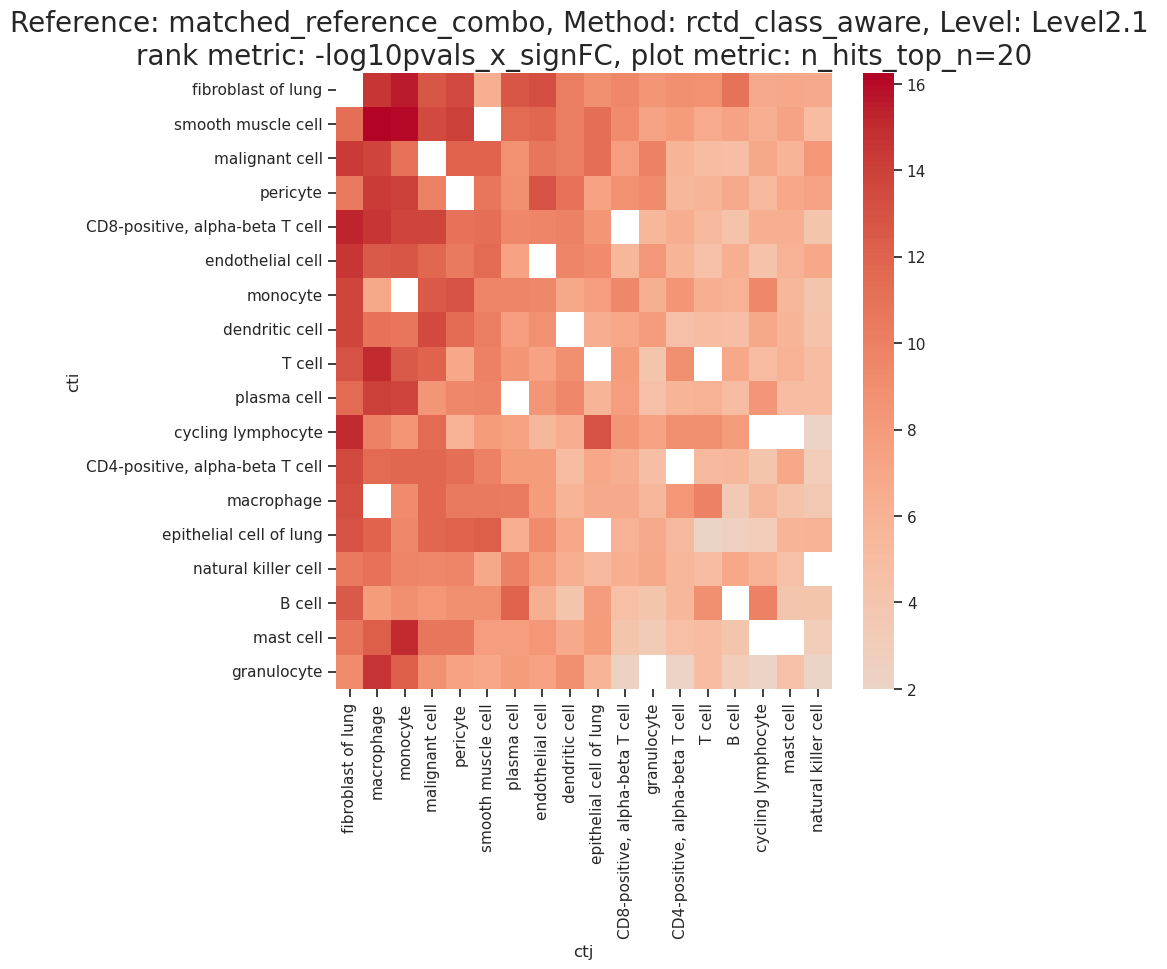

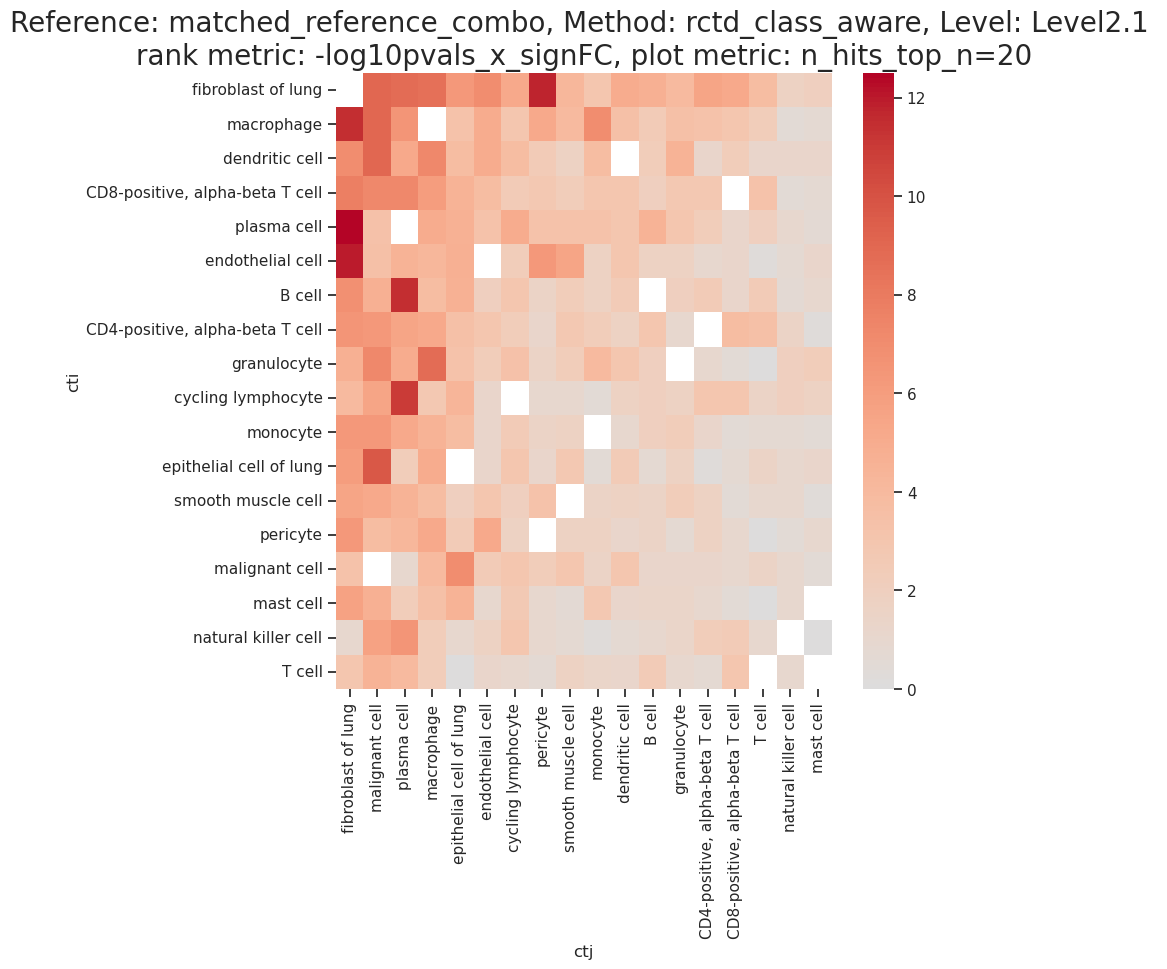

In [147]:
sns.set_style('ticks')
ref_segmentation = '10x_5um'

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({k: v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()}).reset_index()
        df.columns = xenium_levels + df.columns[len(xenium_levels) :-1].tolist() + [plot_metric]

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric])
            plot_metric = '-log10pvalue'

        u_condition_panel = df[['condition','panel']].drop_duplicates().values

        for condition,panel in u_condition_panel:

            df_plot = df.query(f"segmentation == '{ref_segmentation}' and condition == '{condition}' and panel == '{panel}'")
            df_plot = df_plot.groupby(['cti', 'ctj'])[plot_metric].mean().unstack()
            df_plot = df_plot.loc[df_plot.sum(1).sort_values(ascending=False).index]
            df_plot = df_plot[df_plot.sum(0).sort_values(ascending=False).index]

            title = f"Reference: {reference}, Method: {method}, Level: {level} \nrank metric: {rank_metric}, plot metric: {plot_metric}"

            f = plt.figure(figsize=(8,8))
            ax = plt.subplot()
            ax.set_title(title,fontsize=20)
            g = sns.heatmap(df_plot,cmap='coolwarm',center=-np.log10(0.05) if plot_metric == '-log10pvalue' else 0.)
            plt.show()

# Plot decontamination strength

In [ ]:

# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
# probably only need to run for lognorm data
signal_integrity_thresholds = [0.5,0.7]
correction_methods = ['raw','resolvi','resolvi_supervised'] + [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
normalisations = ['lognorm',]
layers = ['data',]
references = ['matched_reference_combo']
methods = ['rctd_class_aware']
levels = ['Level2.1']

n_neighbors = 10
n_permutations = 30
n_repeats = 5
top_n = 20
top_n_lr = 10
scoring = 'f1'

# resolvi params
num_samples = 30
mixture_k = 50

# needed to get unique cell types names for each level
# cell_types_palette = pd.read_csv(palette_dir / 'col_palette_cell_types_combo.csv')

xenium_paths = {}
for correction_method in correction_methods:
    xenium_paths[correction_method] = {}
    for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
        if segmentation.stem == 'proseg_mode':
            continue
        for condition in (conditions := segmentation.iterdir()): 
            for panel in (panels := condition.iterdir()):
                for donor in (donors := panel.iterdir()):
                    for sample in (samples := donor.iterdir()):

                        k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                        name = '/'.join(k)

                        if 'proseg' in segmentation.stem:
                            k_proseg = ('proseg',condition.stem,panel.stem,donor.stem,sample.stem)
                            name_proseg = '/'.join(k_proseg)
                            sample_dir = xenium_dir / f'{name_proseg}/raw_results'
                        else:
                            sample_dir = xenium_dir / f'{name}/normalised_results/outs'
                        
                        # raw samples
                        if correction_method == 'raw':
                            xenium_paths[correction_method][k] = sample_dir
                            continue

                        for normalisation in normalisations:
                            for layer in layers:
                                for reference in references:
                                    for method in methods:
                                        for level in levels:

                                            if correction_method == "resolvi":
                                                name_corrected = f'{name}/{mixture_k=}/{num_samples=}/'
                                            elif correction_method == "resolvi_supervised":
                                                name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}'
                                            elif "ovrlpy" in correction_method:
                                                name_corrected = f'{name}'

                                            sample_corrected_counts_path = results_dir / f"{correction_method}/{name_corrected}/corrected_counts.h5"
                                            sample_normalised_counts = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/{layer}.parquet'
                                            sample_idx = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/cells.parquet'
                                            sample_annotation = xenium_cell_type_annotation_dir / f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/labels.parquet'

                                            xenium_paths[correction_method][k] = sample_corrected_counts_path


xenium_levels = ('segmentation','condition','panel','donor','sample')
ads = readwrite.read_xenium_samples(xenium_paths,anndata_only=True,transcripts=False,sample_name_as_key=False)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def read_count_correction_sample(sample_name, corrected_counts_path):
    return sample_name, sc.read_10x_h5(corrected_counts_path)

xenium_corrected_counts = {}

for correction_method in correction_methods[1:]:
    xenium_corrected_counts[correction_method] = {}

    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(read_count_correction_sample, sample_name, xenium_corr_path): (correction_method, sample_name)
            for sample_name, xenium_corr_path in xenium_paths[correction_method].items()
        }

        # Progress bar with total number of samples
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {correction_method}"):
            try:
                results = future.result()
                if results:
                    method, sample = futures[future]
                    xenium_corrected_counts[method, sample] = results
            except Exception as e:
                print(f"Error processing sample {futures[future]}: {e}")


Processing resolvi:   1%|          | 2/251 [00:00<00:18, 13.49it/s]

Error processing sample ('resolvi', ('proseg_expected', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/proseg_expected/NSCLC/lung/0WMU/0WMU_2/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('proseg_expected', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/proseg_expected/NSCLC/lung/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('proseg_expected', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rg

Processing resolvi:   2%|▏         | 4/251 [00:00<00:58,  4.26it/s]

Error processing sample ('resolvi', ('proseg_expected', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/proseg_expected/NSCLC/chuvio/0WMU/0WMU/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:   2%|▏         | 6/251 [00:01<01:01,  3.98it/s]

Error processing sample ('resolvi', ('proseg_expected', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/proseg_expected/NSCLC/chuvio/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('proseg_expected', 'NSCLC', '5k', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/proseg_expected/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  14%|█▍        | 36/251 [00:03<00:11, 17.98it/s]

Error processing sample ('resolvi', ('segger', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/segger/NSCLC/lung/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('segger', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/segger/NSCLC/lung/0WMU/0WMU_1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  19%|█▊        | 47/251 [00:03<00:06, 29.93it/s]

Error processing sample ('resolvi', ('segger', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/segger/NSCLC/lung/0WMU/0WMU_2/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('segger', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/segger/NSCLC/chuvio/0WMU/0WMU/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('segger', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/r

Processing resolvi:  22%|██▏       | 54/251 [00:03<00:07, 25.32it/s]

Error processing sample ('resolvi', ('segger', 'NSCLC', '5k', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/segger/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  31%|███▏      | 79/251 [00:05<00:08, 20.40it/s]

Error processing sample ('resolvi', ('10x_5um', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_5um/NSCLC/lung/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_5um', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_5um/NSCLC/lung/0WMU/0WMU_2/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  33%|███▎      | 82/251 [00:05<00:08, 19.84it/s]

Error processing sample ('resolvi', ('10x_5um', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_5um/NSCLC/lung/0WMU/0WMU_1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  35%|███▌      | 89/251 [00:05<00:06, 23.17it/s]

Error processing sample ('resolvi', ('10x_5um', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_5um/NSCLC/chuvio/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_5um', 'NSCLC', '5k', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_5um/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  38%|███▊      | 96/251 [00:05<00:06, 22.88it/s]

Error processing sample ('resolvi', ('10x_5um', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_5um/NSCLC/chuvio/0WMU/0WMU/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  48%|████▊     | 120/251 [00:07<00:08, 15.32it/s]

Error processing sample ('resolvi', ('10x_15um', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_15um/NSCLC/lung/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_15um', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_15um/NSCLC/lung/0WMU/0WMU_1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_15um', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/res

Processing resolvi:  53%|█████▎    | 134/251 [00:08<00:05, 21.64it/s]

Error processing sample ('resolvi', ('10x_15um', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_15um/NSCLC/chuvio/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_15um', 'NSCLC', '5k', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_15um/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  55%|█████▍    | 137/251 [00:08<00:05, 21.85it/s]

Error processing sample ('resolvi', ('10x_mm_5um', 'NSCLC', '5k', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_mm_5um/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_15um', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_15um/NSCLC/chuvio/0WMU/0WMU/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  66%|██████▌   | 165/251 [00:10<00:04, 18.77it/s]

Error processing sample ('resolvi', ('baysor', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/baysor/NSCLC/lung/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  69%|██████▉   | 173/251 [00:10<00:04, 17.93it/s]

Error processing sample ('resolvi', ('baysor', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/baysor/NSCLC/lung/0WMU/0WMU_1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('baysor', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/baysor/NSCLC/lung/0WMU/0WMU_2/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('baysor', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/r

Processing resolvi:  71%|███████▏  | 179/251 [00:11<00:04, 14.86it/s]

Error processing sample ('resolvi', ('baysor', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/baysor/NSCLC/chuvio/0WMU/0WMU/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi:  82%|████████▏ | 205/251 [00:12<00:02, 17.04it/s]

Error processing sample ('resolvi', ('10x_0um', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_0um/NSCLC/lung/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_0um', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_0um/NSCLC/lung/0WMU/0WMU_1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_0um', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/

Processing resolvi:  88%|████████▊ | 222/251 [00:13<00:00, 32.38it/s]

Error processing sample ('resolvi', ('10x_0um', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_0um/NSCLC/chuvio/1G73/1G73/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_0um', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_0um/NSCLC/chuvio/0WMU/0WMU/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi', ('10x_0um', 'NSCLC', '5k', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/

Processing resolvi_supervised:   0%|          | 0/251 [00:00<?, ?it/s]

Error processing sample ('resolvi_supervised', ('segger', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/segger/NSCLC/lung/1G73/1G73/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi_supervised', ('10x_5um', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_5um/NSCLC/lung/0WMU/0WMU_2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolv

Processing resolvi_supervised:  41%|████▏     | 104/251 [00:00<00:00, 372.09it/s]

Error processing sample ('resolvi_supervised', ('10x_15um', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_15um/NSCLC/lung/1G73/1G73/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi_supervised', ('10x_15um', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_15um/NSCLC/lung/0WMU/0WMU_1/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('

Processing resolvi_supervised:  63%|██████▎   | 159/251 [00:03<00:02, 31.59it/s] 

Error processing sample ('resolvi_supervised', ('baysor', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/baysor/NSCLC/lung/1G73/1G73/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi_supervised:  67%|██████▋   | 169/251 [00:04<00:03, 25.65it/s]

Error processing sample ('resolvi_supervised', ('baysor', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/baysor/NSCLC/lung/0WMU/0WMU_1/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi_supervised', ('baysor', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/baysor/NSCLC/lung/0WMU/0WMU_2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi_supervised:  73%|███████▎  | 182/251 [00:05<00:02, 24.80it/s]

Error processing sample ('resolvi_supervised', ('baysor', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/baysor/NSCLC/chuvio/1G73/1G73/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi_supervised', ('baysor', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/baysor/NSCLC/chuvio/0WMU/0WMU/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi_supervised:  82%|████████▏ | 207/251 [00:07<00:02, 18.77it/s]

Error processing sample ('resolvi_supervised', ('10x_0um', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_0um/NSCLC/lung/1G73/1G73/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi_supervised:  84%|████████▎ | 210/251 [00:07<00:02, 19.09it/s]

Error processing sample ('resolvi_supervised', ('10x_0um', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_0um/NSCLC/lung/0WMU/0WMU_1/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi_supervised', ('10x_0um', 'NSCLC', 'lung', '0WMU', '0WMU_2')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_0um/NSCLC/lung/0WMU/0WMU_2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing resolvi_supervised:  86%|████████▌ | 216/251 [00:07<00:02, 15.39it/s]

Error processing sample ('resolvi_supervised', ('10x_0um', 'NSCLC', 'chuvio', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_0um/NSCLC/chuvio/1G73/1G73/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('resolvi_supervised', ('10x_0um', 'NSCLC', 'chuvio', '0WMU', '0WMU')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_0um/NSCLC/chuvio/0WMU/0WMU/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('

Processing resolvi_supervised: 100%|██████████| 251/251 [00:08<00:00, 28.20it/s]
Processing ovrlpy_correction_signal_integrity_threshold=0.5:   0%|          | 0/251 [00:00<?, ?it/s]

Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('10x_15um', 'NSCLC', '5k', '1GVD', '1GVD')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('proseg_expected', 'NSCLC', '5k', '1GVD', '1GVD')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/5k/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('proseg_expected', 'NSCLC', 'c

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  76%|███████▌  | 191/251 [00:00<00:00, 389.04it/s]

Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('10x_0um', 'NSCLC', 'lung', '0WMU', '0WMU_1')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/lung/0WMU/0WMU_1/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('10x_0um', 'NSCLC', 'lung', '1G73', '1G73')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/lung/1G73/1G73/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('10x_0um', 'NSCLC', 'lung', '0WMU', 

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  92%|█████████▏| 230/251 [00:03<00:00, 56.46it/s] 

Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.5', ('10x_0um', 'NSCLC', '5k', '1GAC', '1GAC')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.5: 100%|██████████| 251/251 [00:03<00:00, 66.95it/s]
Processing ovrlpy_correction_signal_integrity_threshold=0.7: 100%|██████████| 251/251 [00:00<00:00, 16991.13it/s]

Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.7', ('baysor', 'NSCLC', '5k', '1GDD', '1GDD')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/1GDD/1GDD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.7', ('10x_15um', 'NSCLC', '5k', '0PSV', '0PSV')): [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error processing sample ('ovrlpy_correction_signal_integrity_threshold=0.7', ('proseg_expected', 'NSCLC', 'lung', '0S8R', '0S8

In [23]:
n_genes = ((xenium_corrected_counts[method, sample].X>0).sum(1)).A1
n_counts = ((xenium_corrected_counts[method, sample].X).sum(1)).A1